# **Stage 1**

In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

In [ ]:
import cv2

import os
import shutil

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image

Split the data 70/10/20% into train/validation/test sets.

In [ ]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):

    list_copy = image_id_list.copy()
    random.shuffle(list_copy)

    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)

    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

Load the data


In [ ]:
train_path = "/content/drive/MyDrive/chest_xray/train"
test_path = "/content/drive/MyDrive/chest_xray/test"
val_path = "/content/drive/MyDrive/chest_xray/val"

In [ ]:
Train_PNEUMONIA = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA'
Train_NORMAL = '/content/drive/MyDrive/chest_xray/train/NORMAL'

Test_PNEUMONIA = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA'
Test_NORMAL = '/content/drive/MyDrive/chest_xray/test/NORMAL'

Data  analysis：train

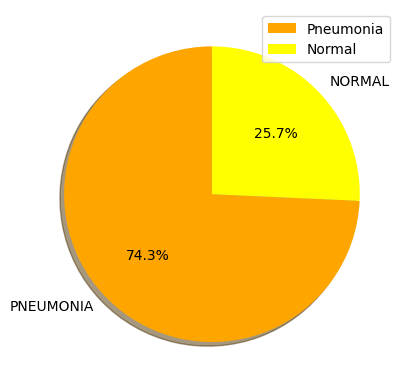

In [ ]:
class_classify = os.listdir(train_path)
class_classify.remove('.DS_Store')
image_count = {}
for i in class_classify:

    image_count[i] = len(os.listdir(os.path.join(train_path,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90,
        colors=["orange","yellow"])
plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

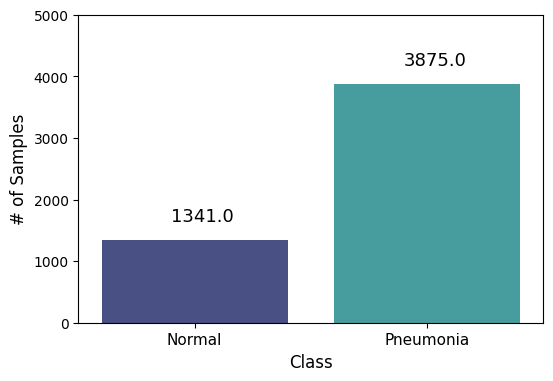

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)

plt.show()

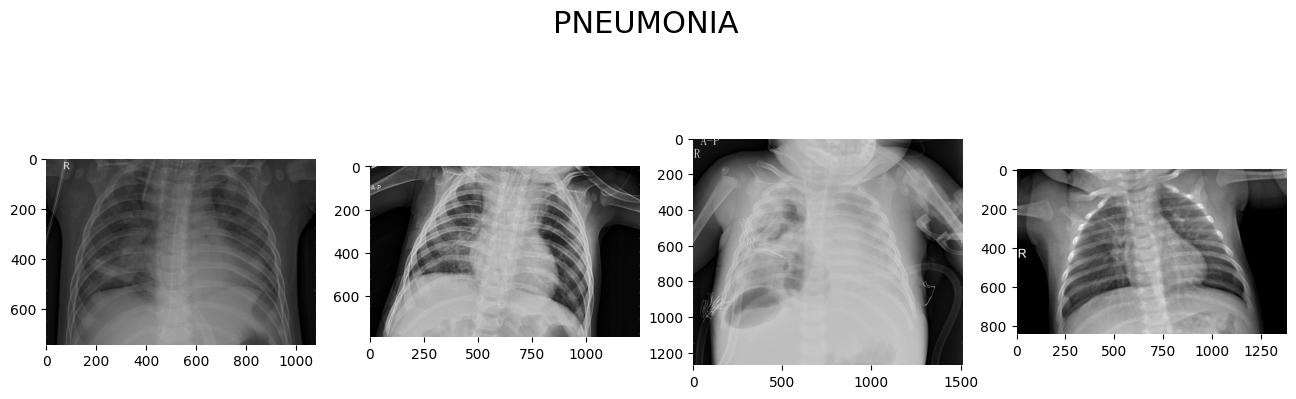

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("PNEUMONIA", size=22)
img_paths = os.listdir(Train_PNEUMONIA)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(Train_PNEUMONIA, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

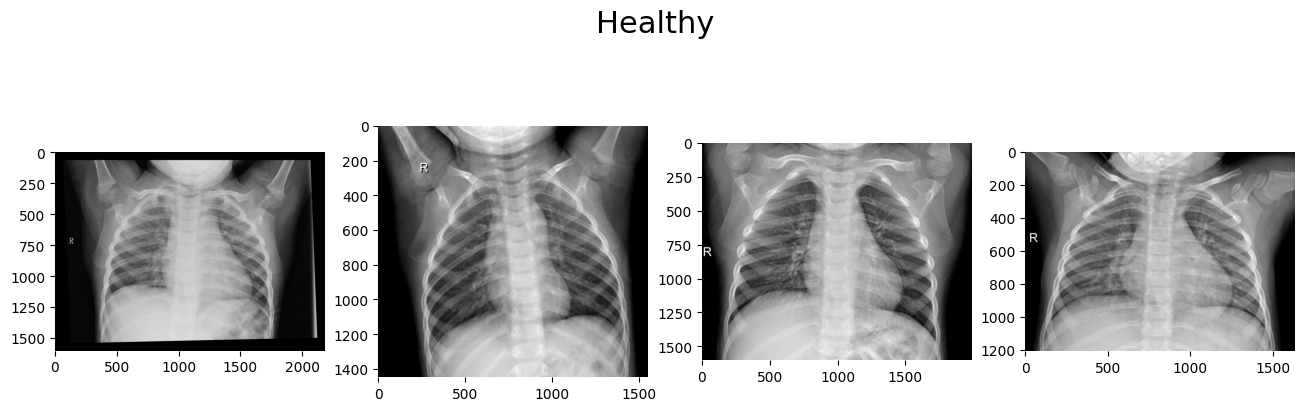

In [ ]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("Healthy", size=22)
img_paths = os.listdir(Train_NORMAL)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(Train_NORMAL, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

Data preparation

In [ ]:
import glob
Train_NORMAL = glob.glob(train_path+"/NORMAL/*.jpeg")
Train_PNEUMONIA = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

Test_NORMAL = glob.glob(test_path+"/NORMAL/*.jpeg")
Test_PNEUMONIA = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [ ]:
train_list = [x for x in Train_NORMAL]
train_list.extend([x for x in Train_PNEUMONIA])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(Train_NORMAL) , ['Pneumonia']*len(Train_PNEUMONIA)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in Test_NORMAL]
test_list.extend([x for x in Test_PNEUMONIA])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(Test_NORMAL) , ['Pneumonia']*len(Test_PNEUMONIA)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [ ]:
df_train

class                                              image
0        Normal  /content/drive/MyDrive/chest_xray/train/NORMAL...
1        Normal  /content/drive/MyDrive/chest_xray/train/NORMAL...
2        Normal  /content/drive/MyDrive/chest_xray/train/NORMAL...
3        Normal  /content/drive/MyDrive/chest_xray/train/NORMAL...
4        Normal  /content/drive/MyDrive/chest_xray/train/NORMAL...
...         ...                                                ...
5211  Pneumonia  /content/drive/MyDrive/chest_xray/train/PNEUMO...
5212  Pneumonia  /content/drive/MyDrive/chest_xray/train/PNEUMO...
5213  Pneumonia  /content/drive/MyDrive/chest_xray/train/PNEUMO...
5214  Pneumonia  /content/drive/MyDrive/chest_xray/train/PNEUMO...
5215  Pneumonia  /content/drive/MyDrive/chest_xray/train/PNEUMO...

[5216 rows x 2 columns]

In [ ]:
from torchvision import transforms

Data augmention

Transforms

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes
                                transforms.RandomRotation(10), # Rotates
                                transforms.RandomHorizontalFlip(p=0.4),
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [ ]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['train'])
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(train_path, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes

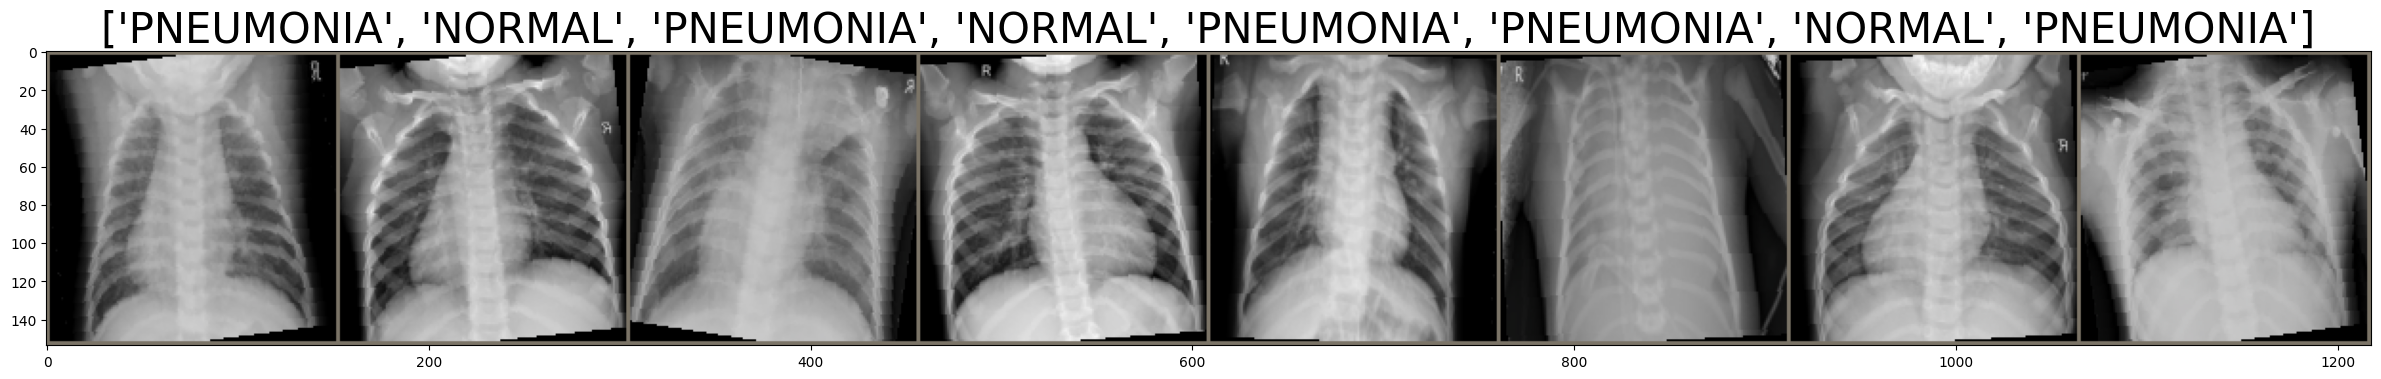

In [ ]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class_names

['NORMAL', 'PNEUMONIA']

# **CNN**

In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")
torch.cuda.empty_cache()

Training on CPU... May the force be with you...


In [ ]:
def CNN(pretrained=True):
    model = models.densenet121(pretrained=pretrained)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)
    return model

model = CNN(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 65.0MB/s]


In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6955906


Tarin model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()
            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)


                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=3)


Epoch 1/3
----------


train:   0%|          | 0/522 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

train Loss: 0.3008 | train Accuracy: 0.8886


val:   0%|          | 0/131 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

val Loss: 0.1606 | val Accuracy: 0.9415 | Kappa Score: nan
Val loss Decreased from inf to 0.1606 
Saving Weights... 

Epoch 2/3
----------


train:   0%|          | 0/522 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

train Loss: 0.3023 | train Accuracy: 0.8876


val:   0%|          | 0/131 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

val Loss: 0.1550 | val Accuracy: 0.9406 | Kappa Score: nan
Val loss Decreased from 0.1606 to 0.1550 
Saving Weights... 

Epoch 3/3
----------


train:   0%|          | 0/522 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

train Loss: 0.2921 | train Accuracy: 0.8902


val:   0%|          | 0/131 [00:00<?, ?it/s]

4hfor 10 epoch cnn

In [ ]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=8)


Epoch 1/8
----------


train:   0%|          | 0/522 [00:00<?, ?it/s]

train Loss: 0.5547 | train Accuracy: 0.8505


val:   0%|          | 0/131 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

val Loss: 0.3925 | val Accuracy: 0.8917 | Kappa Score: nan
Val loss Decreased from inf to 0.3925 
Saving Weights... 

Epoch 2/8
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/522 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.5588 | train Accuracy: 0.8538


val:   0%|          | 0/131 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

val Loss: 0.3977 | val Accuracy: 0.8955 | Kappa Score: nan

Epoch 3/8
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/522 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.5450 | train Accuracy: 0.8560


val:   0%|          | 0/131 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.3876 | val Accuracy: 0.8955 | Kappa Score: nan
Val loss Decreased from 0.3925 to 0.3876 
Saving Weights... 

Epoch 4/8
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/522 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.5334 | train Accuracy: 0.8557


val:   0%|          | 0/131 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

val Loss: 0.3906 | val Accuracy: 0.8917 | Kappa Score: nan

Epoch 5/8
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/522 [00:00<?, ?it/s]

train Loss: 0.5415 | train Accuracy: 0.8529


val:   0%|          | 0/131 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

val Loss: 0.3737 | val Accuracy: 0.8926 | Kappa Score: nan
Val loss Decreased from 0.3876 to 0.3737 
Saving Weights... 

Epoch 6/8
----------


train:   0%|          | 0/522 [00:00<?, ?it/s]

train Loss: 0.5439 | train Accuracy: 0.8591


val:   0%|          | 0/131 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

val Loss: 0.3952 | val Accuracy: 0.8907 | Kappa Score: nan

Epoch 7/8
----------


train:   0%|          | 0/522 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.5695 | train Accuracy: 0.8495


val:   0%|          | 0/131 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

val Loss: 0.3968 | val Accuracy: 0.8984 | Kappa Score: nan

Epoch 8/8
----------


train:   0%|          | 0/522 [00:00<?, ?it/s]

train Loss: 0.5442 | train Accuracy: 0.8579


val:   0%|          | 0/131 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/pytho

val Loss: 0.4198 | val Accuracy: 0.8840 | Kappa Score: nan

Training complete in 205m 9s
Best val loss: 0.3737


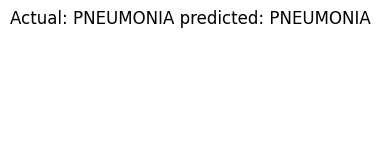

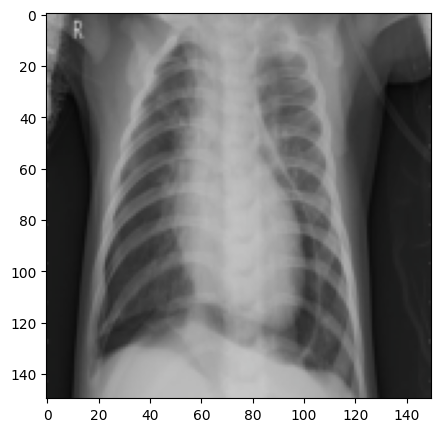

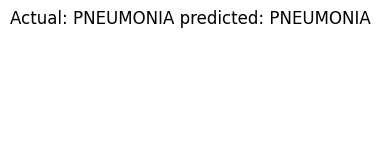

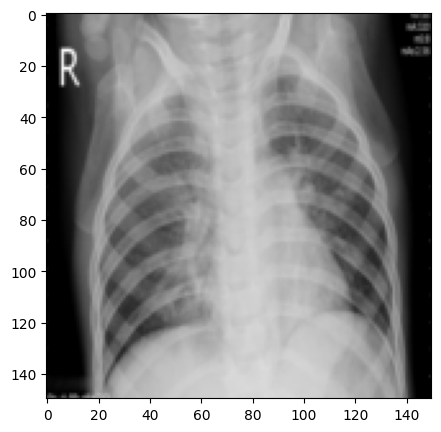

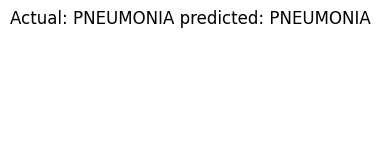

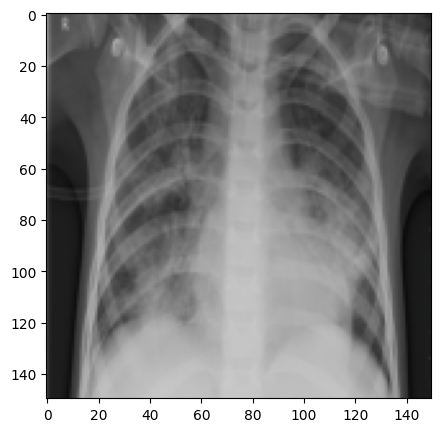

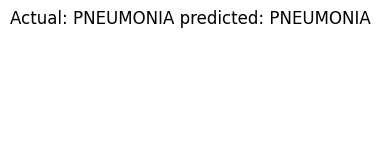

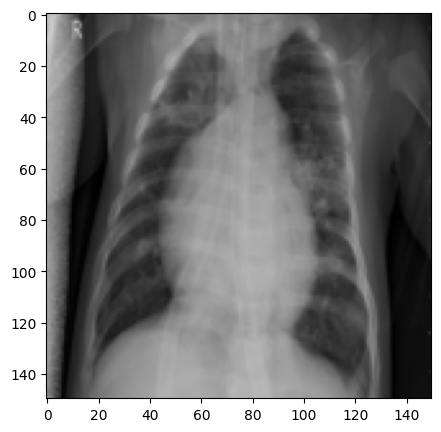

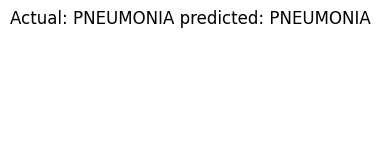

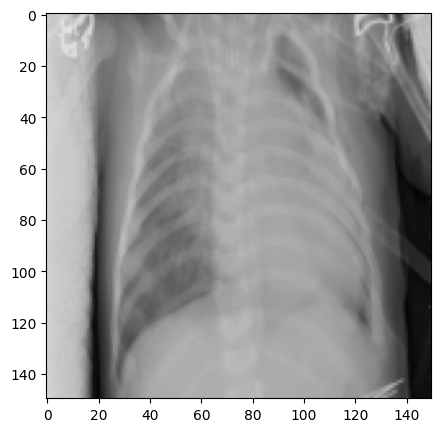

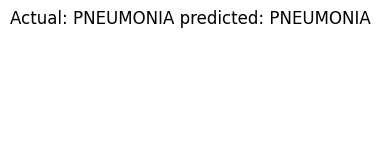

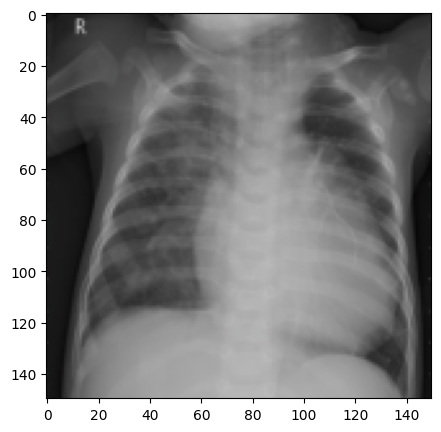

In [ ]:
visualize_model(base_model)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_stats(train_losses, val_losses, train_accs, val_accs, val_kappas):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy and Kappa Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r', label='Validation Accuracy')
    # plt.plot(epochs, val_kappas, 'g', label='Validation Kappa')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / Kappa Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call the function to plot the training stats
plot_training_stats(val_loss, val_acc, current_loss, current_corrects)


NameError: ignored

Test

In [ ]:
TEST_DATA_PATH = '/content/drive/MyDrive/chest_xray/test'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/674 [00:00<?, ?it/s]

In [ ]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

Precision    Recall  F1-score

classification_report() is a function used to calculate performance metrics in classification tasks, it can accept true labels (y_true_list) and predicted labels (y_pred_list) as input, and generate reports containing metrics such as accuracy, recall, F1 value, etc.

In [ ]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.89      0.61      0.72       261
           1       0.79      0.95      0.87       413

    accuracy                           0.82       674
   macro avg       0.84      0.78      0.79       674
weighted avg       0.83      0.82      0.81       674



In [ ]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.86      0.59      0.70       261
           1       0.78      0.94      0.85       413

    accuracy                           0.80       674
   macro avg       0.82      0.76      0.78       674
weighted avg       0.81      0.80      0.79       674



confusion_matrix

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['Pneumonia','normal'],
                      title        = "Confusion Matrix")

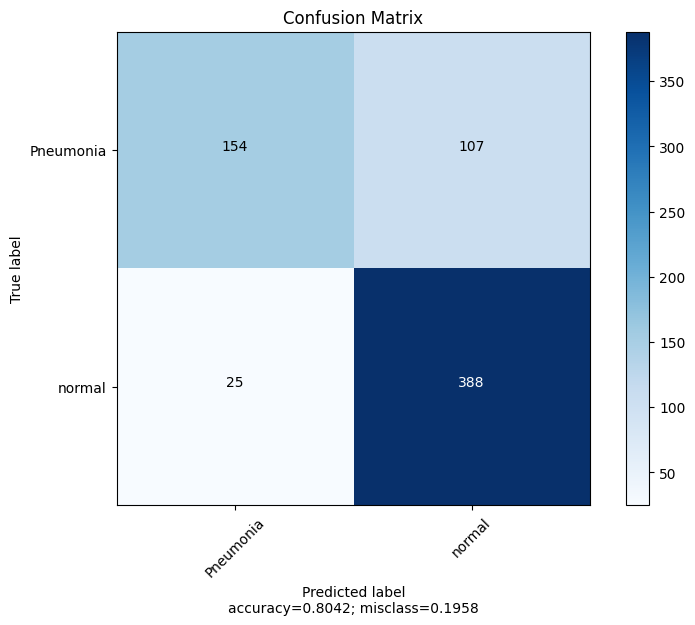

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['Pneumonia','normal'],
                      title        = "Confusion Matrix")

1.show the process of 2.difference

Tensorflow

ResNet

In [ ]:
import torch
import torch.nn as nn

# Define the basic building block of ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

#


# **VGG**

In [ ]:
import torch
import torch.nn as nn

# Define the VGG architecture
class VGG(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of the VGG model
model = VGG()

# Print the model architecture
print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split


In [ ]:
from tqdm.notebook import tqdm
from termcolor import colored
import albumentations as A

In [ ]:
print(tensorflow.config.list_physical_devices("GPU"))

print("________________________________________________")

print(tensorflow.test.is_gpu_available(cuda_only = False, min_cuda_compute_capability = None))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[]
________________________________________________
False


In [ ]:
print("Current tensorflow version == {}".format(tensorflow. __version__))

Current tensorflow version == 2.12.0


In [ ]:
train_df = glob.glob("/content/drive/MyDrive/chest_xray/train/**/*.jpeg")
test_df = glob.glob("/content/drive/MyDrive/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("/content/drive/MyDrive/chest_xray/val/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...


In [ ]:
train_df[:5]

['/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person501_bacteria_2114.jpeg',
 '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person536_bacteria_2260.jpeg',
 '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person507_bacteria_2141.jpeg',
 '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person540_bacteria_2272.jpeg',
 '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person515_bacteria_2187.jpeg']

In [ ]:
test_df[:5]

['/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0006-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0025-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0035-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0015-0001 (1).jpeg',
 '/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0029-0001 (1).jpeg']

In [ ]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5216 images in the training dataset
There is 674 images in the test dataset
There is 16 images in the validation dataset


In [ ]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

CPU times: user 577 ms, sys: 18.8 ms, total: 596 ms
Wall time: 745 ms


In [ ]:
from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
directory = "/content/drive/MyDrive/chest_xray"

In [ ]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4296
The number of non-pneumonia images is 1610


TypeError: ignored

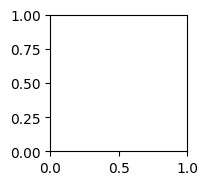

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 读取图像
image_path = '/content/drive/MyDrive/COVID19_Radiography_Dataset/COVID/images/COVID-1.png'
image = Image.open(image_path)
image = np.expand_dims(image, axis=0)

# 显示原始图像
plt.figure(figsize=(6, 6))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

# 数据增强参数
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# 转换图像为数组
image_array = np.array(image)
image_array = image_array.reshape((1,) + image_array.shape)

# 数据增强
augmented_images = []
for batch in datagen.flow(image_array, batch_size=1):
    augmented_images.append(batch[0])
    if len(augmented_images) >= 3:  # 生成3种变换后的图像
        break

# 显示数据增强后的图像
for i, augmented_image in enumerate(augmented_images):
    plt.subplot(1, 3, i + 2)
    plt.imshow(augmented_image.astype(np.uint8))
    plt.title('Augmented Image {}'.format(i + 1))

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Assuming 'input_image' is your input data
 # Add batch dimension

# Now the shape of 'input_image' should be (1, 299, 299, channels)


NameError: ignored

# **VGG- Data augmentation**

Shuffle the images

In [ ]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0447-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0385-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0306-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-0443-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL2-IM-0146-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-1128-0001-0002.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-1051-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-1044-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-0997-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0535-0001.jpeg']

NORMAL


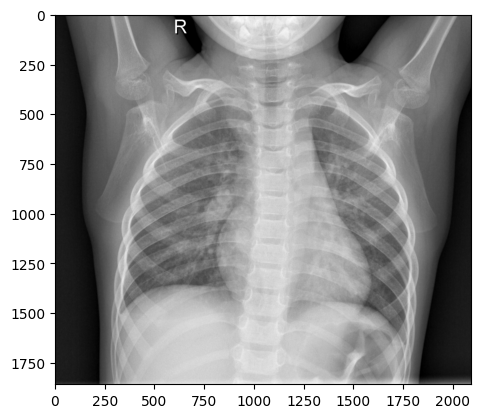

In [ ]:
normal_lung_image = load_img("/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()



# **Basic morphological operation**






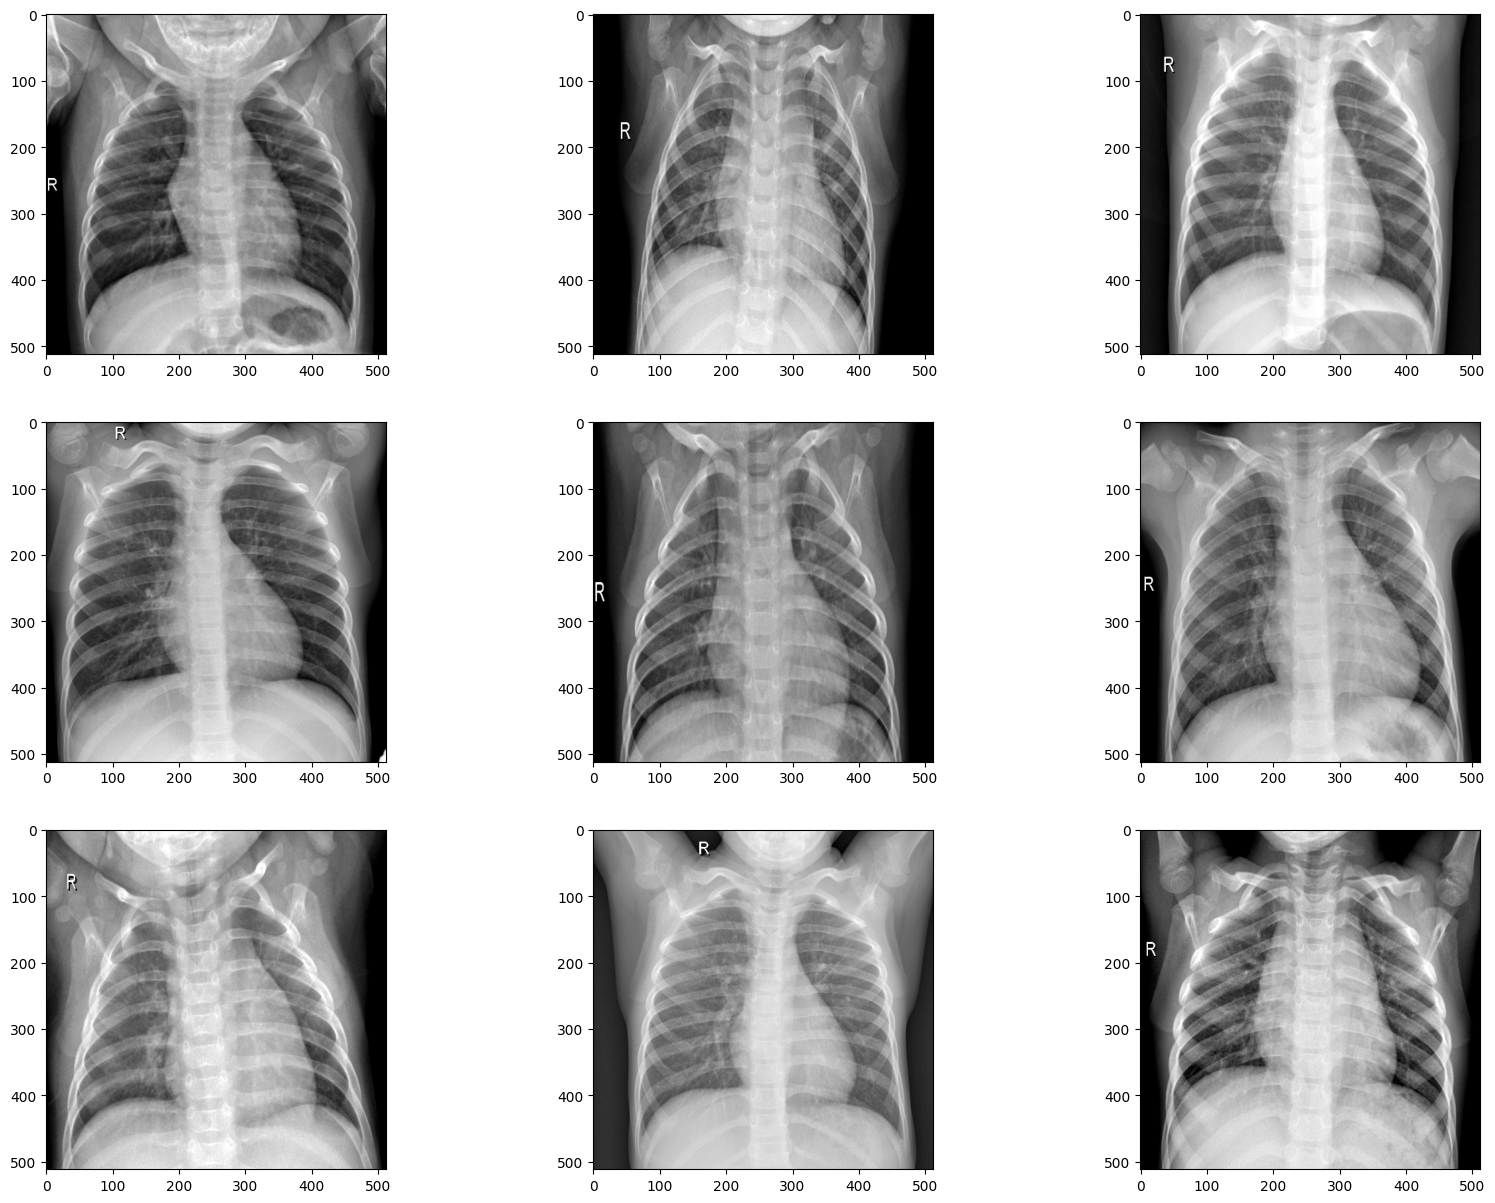

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

Image erosion
The erosion operation works by sliding a structuring element (usually a rectangular or circular kernel) over the image and comparing the kernel with the pixels underneath. If all the pixels in the kernel are non-zero (white pixels), then the center pixel is set to white; otherwise, it is set to black.
By using the cv2.erode() function, the kernel is applied to each image, performing the specified number of erosion operations. In the given code, a rectangular kernel of size (5, 5) is used, and it is applied to the img image three times.

The effect of image erosion is to shrink the objects in the image, making their edges smoother. It can be used for noise removal, separating connected objects, improving edge detection, and other tasks.

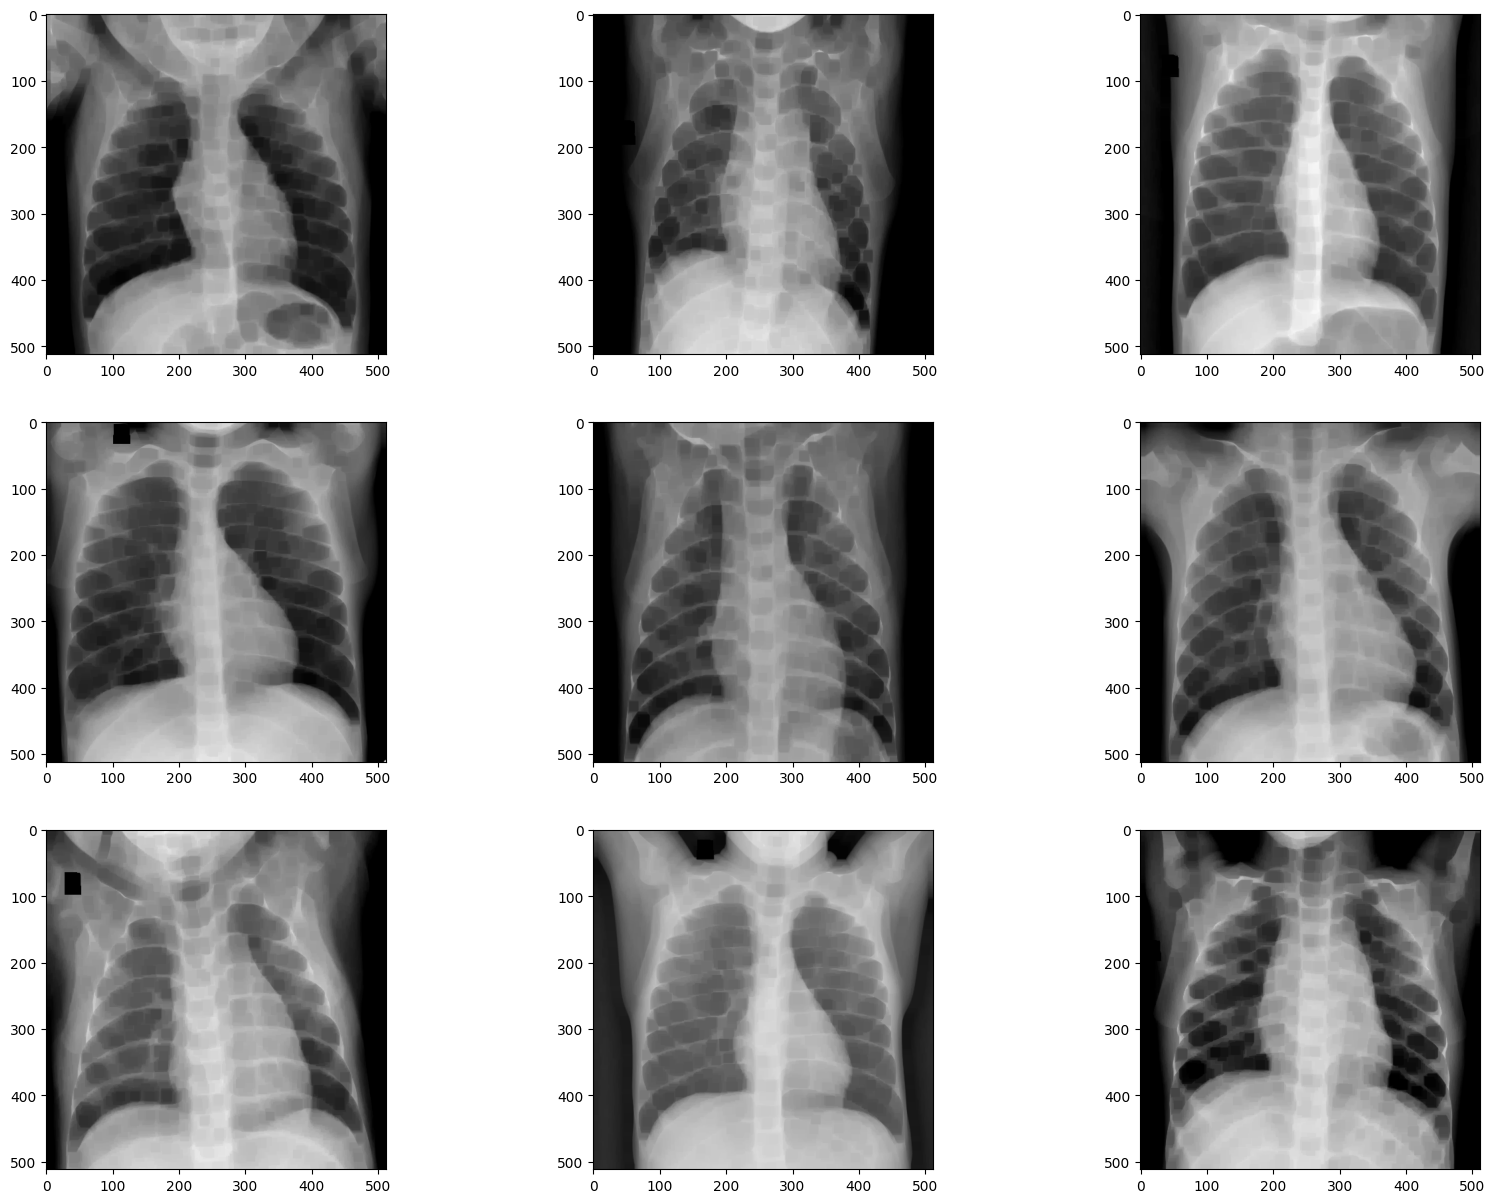

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

Image dilation

Image dilation is another basic morphological operation that is often used in image processing. It is the opposite of image erosion and is used to expand or enlarge the boundaries of objects in an image.

Dilation is performed by sliding a structuring element (kernel) over the image and comparing it with the pixels underneath. If at least one pixel in the kernel is non-zero (white), the center pixel is set to white. This process helps to grow or expand the regions of white pixels in the image.

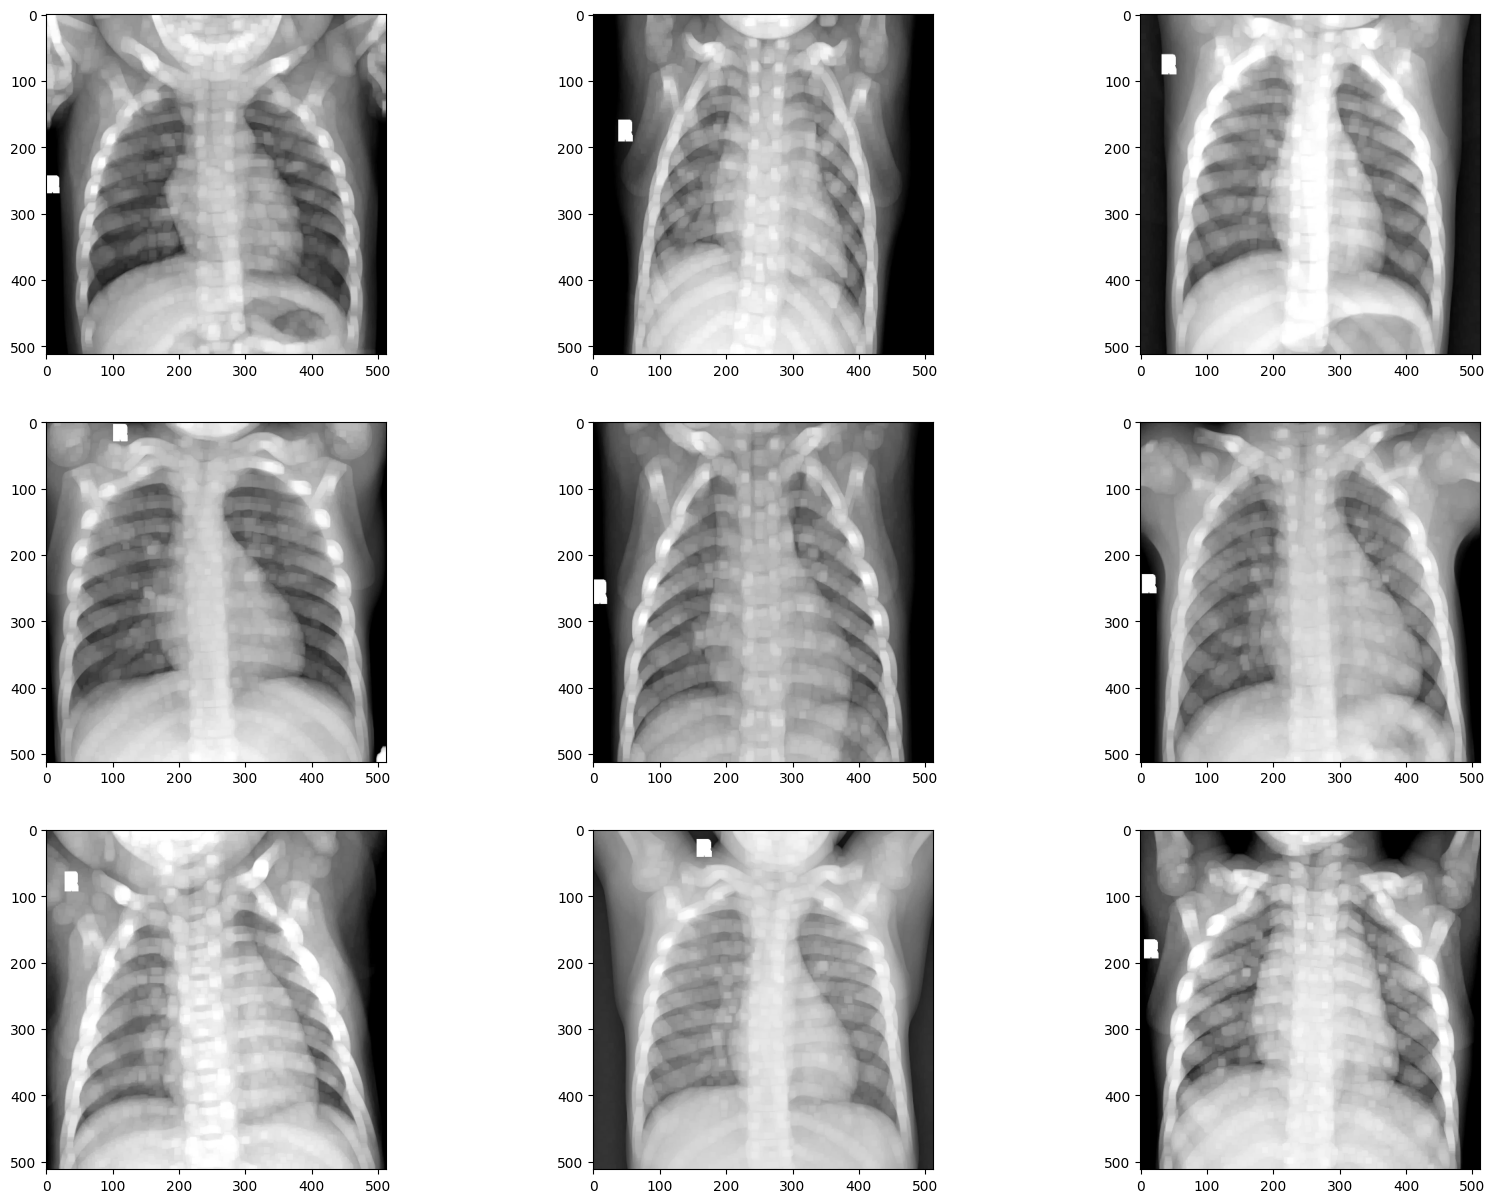

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_dilation = cv2.dilate(img, kernel, iterations = 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_dilation)

Convert the images to greyscale and then apply Gaussian blur to them

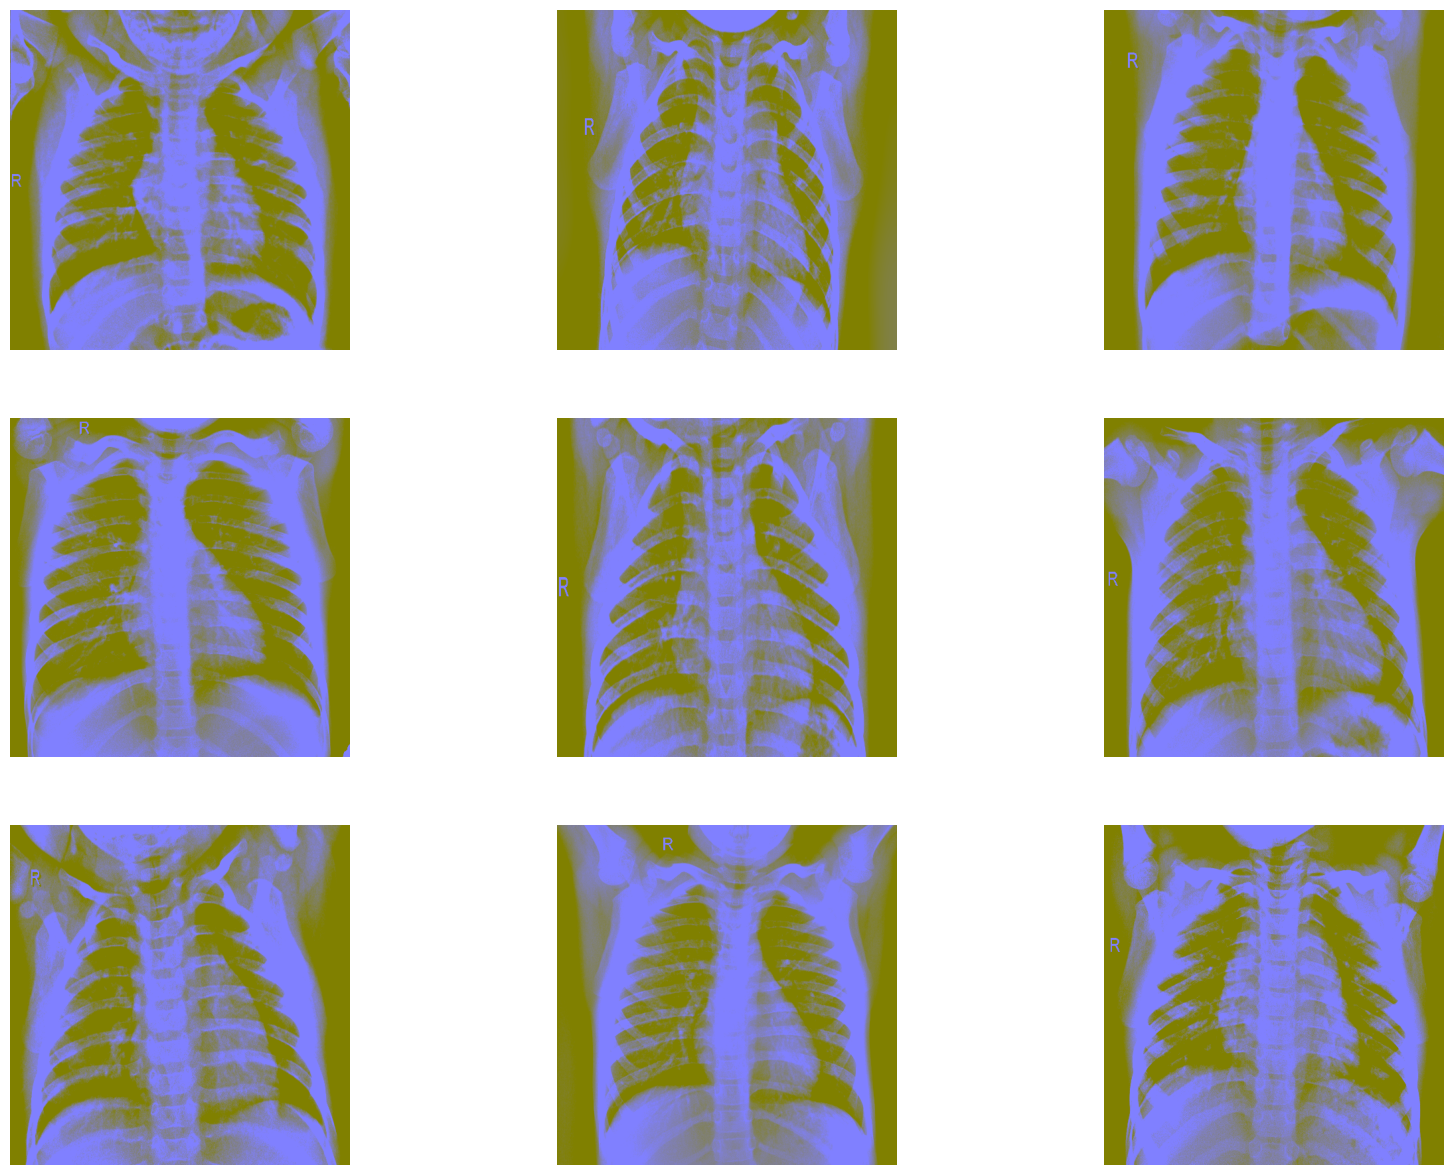

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

Canny edge detection

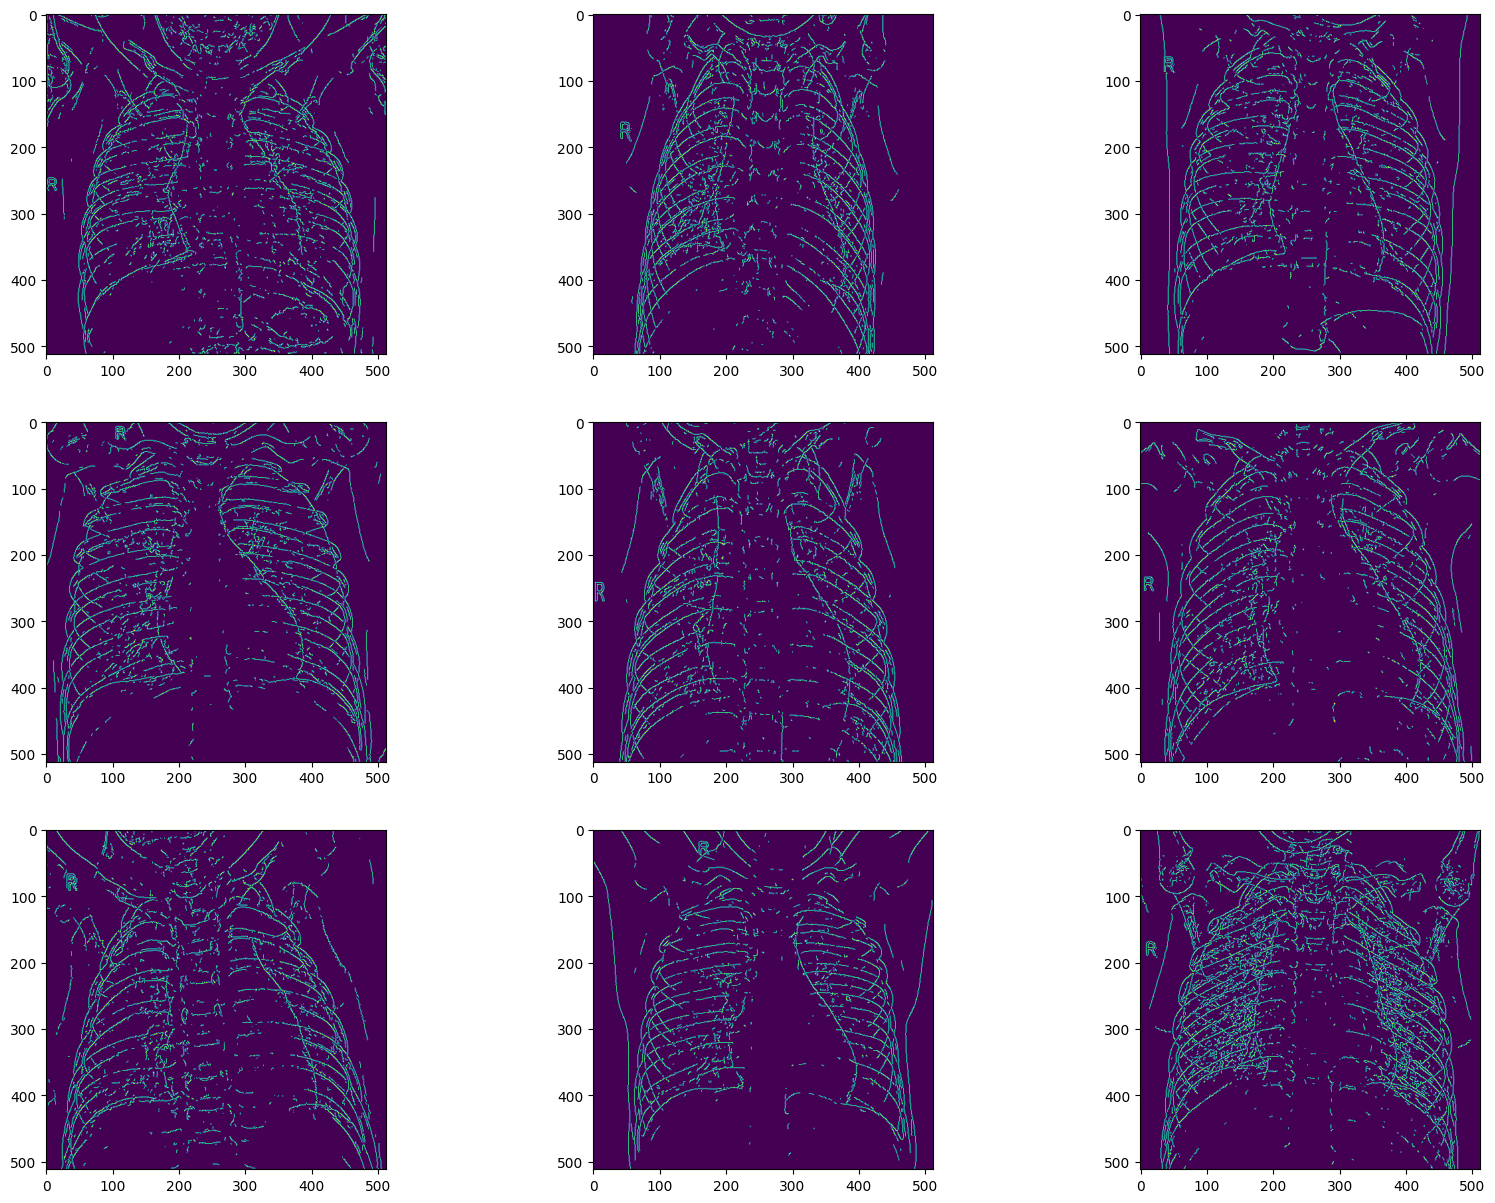

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

In [ ]:
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir = "/content/drive/MyDrive/chest_xray/test"
validation_dir = "/content/drive/MyDrive/chest_xray/val"

In [ ]:
train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 674 images belonging to 2 classes.


In [ ]:
base_model1 = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3), pooling = "max",
                    classes = 2)

#base_model1.load_weights("/content/drive/MyDrive/results/my_pneumonia_detection_model.h5")
base_model1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split


based  on the pretrain model

In [ ]:
model2 = Sequential()
model2.add(base_model1)
model2.add(Flatten())

model2.add(Dense(128, activation = "relu"))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model1.layers:
    layer.trainable = False

model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

In [ ]:
history = model2.fit_generator(train_set, epochs = 40, validation_data = validation_set, steps_per_epoch = 100,
                               callbacks = [early_stopping_callbacks])

Epoch 1/40
100/100 [==============================] - 1129s 11s/step - loss: 0.3996 - accuracy: 0.7975 - val_loss: 0.6782 - val_accuracy: 0.6875
Epoch 2/40
100/100 [==============================] - 1104s 11s/step - loss: 0.3171 - accuracy: 0.8562 - val_loss: 0.3839 - val_accuracy: 0.8125
Epoch 3/40
100/100 [==============================] - 1097s 11s/step - loss: 0.2848 - accuracy: 0.8612 - val_loss: 1.3113 - val_accuracy: 0.6875
Epoch 4/40
100/100 [==============================] - 1097s 11s/step - loss: 0.2878 - accuracy: 0.8700 - val_loss: 0.4860 - val_accuracy: 0.7500
Epoch 5/40
100/100 [==============================] - 1115s 11s/step - loss: 0.2576 - accuracy: 0.8931 - val_loss: 1.1596 - val_accuracy: 0.6875
Epoch 6/40
100/100 [==============================] - 1098s 11s/step - loss: 0.2637 - accuracy: 0.8906 - val_loss: 0.7160 - val_accuracy: 0.7500
Epoch 7/40
100/100 [==============================] - 1099s 11s/step - loss: 0.2580 - accuracy: 0.8925 - val_loss: 0.8271 - val_ac

In [ ]:
history = model2.fit_generator(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100,
                               callbacks = [early_stopping_callbacks])

Epoch 1/20
100/100 [==============================] - 1125s 11s/step - loss: 0.3682 - accuracy: 0.8325 - val_loss: 0.4798 - val_accuracy: 0.7500
Epoch 2/20
100/100 [==============================] - 1110s 11s/step - loss: 0.3296 - accuracy: 0.8462 - val_loss: 0.6688 - val_accuracy: 0.6875
Epoch 3/20
100/100 [==============================] - 1130s 11s/step - loss: 0.2932 - accuracy: 0.8644 - val_loss: 0.3698 - val_accuracy: 0.8125
Epoch 4/20
100/100 [==============================] - 1121s 11s/step - loss: 0.2875 - accuracy: 0.8763 - val_loss: 0.4372 - val_accuracy: 0.7500
Epoch 5/20
100/100 [==============================] - 1096s 11s/step - loss: 0.2769 - accuracy: 0.8800 - val_loss: 0.3924 - val_accuracy: 0.6875
Epoch 6/20
100/100 [==============================] - 1100s 11s/step - loss: 0.2829 - accuracy: 0.8750 - val_loss: 0.4098 - val_accuracy: 0.6875
Epoch 7/20
100/100 [==============================] - 1095s 11s/step - loss: 0.2441 - accuracy: 0.8975 - val_loss: 0.4419 - val_ac

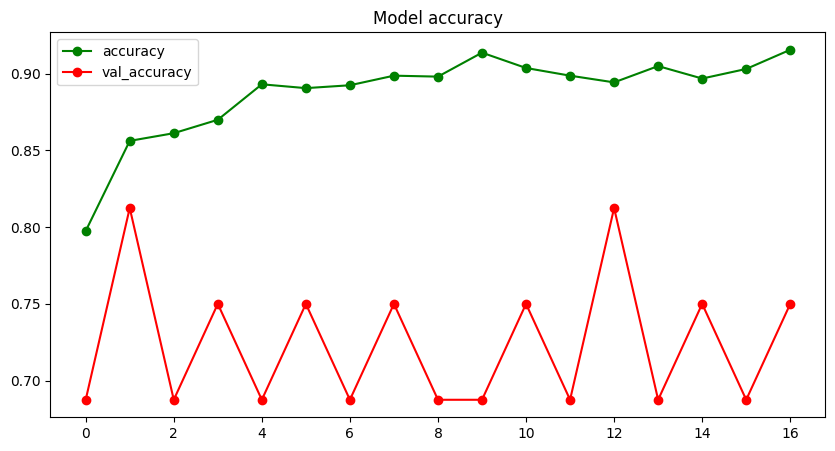

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

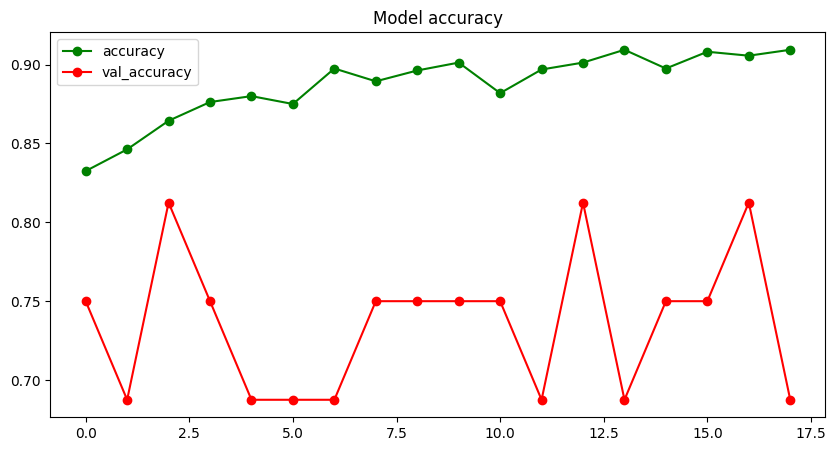

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

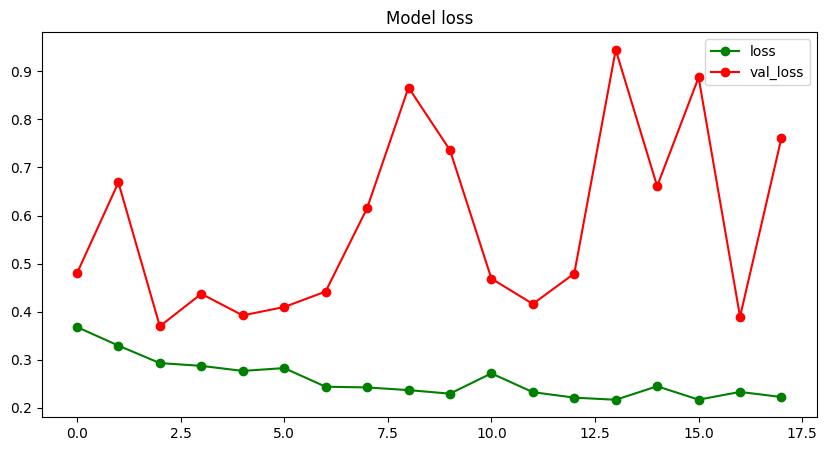

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

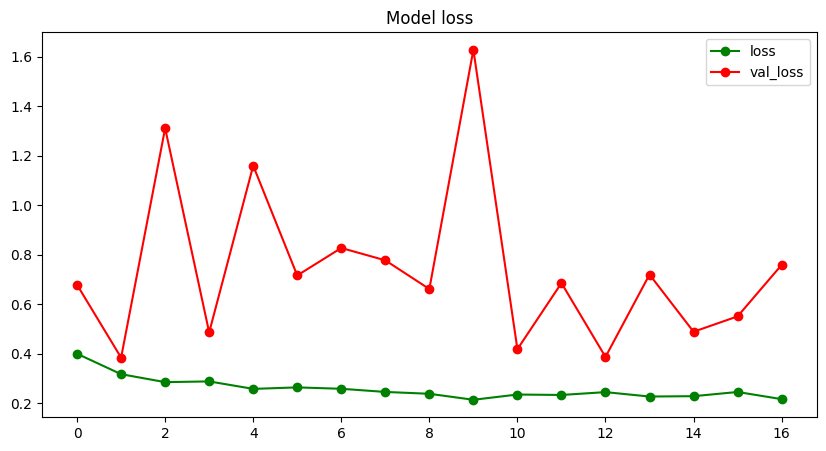

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

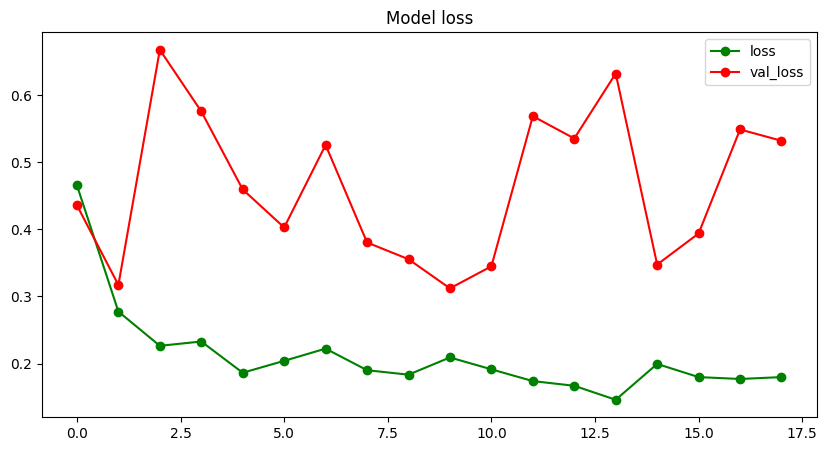

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

In [ ]:
test_loss, test_accuracy = model2.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

43/50 [========================>.....] - ETA: 44s - loss: 0.3932 - accuracy: 0.8635

50/50 [==============================] - 274s 5s/step - loss: 0.3932 - accuracy: 0.8635
The testing accuracy is:  86.3501489162445 %
The testing loss is:  39.323389530181885 %


In [ ]:
test_loss, test_accuracy = model2.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

43/50 [========================>.....] - ETA: 44s - loss: 0.6940 - accuracy: 0.6128

50/50 [==============================] - 278s 6s/step - loss: 0.6940 - accuracy: 0.6128
The testing accuracy is:  61.275964975357056 %
The testing loss is:  69.39653158187866 %


In [ ]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model3.fit_generator(train_set, epochs = 18, validation_data = validation_set, steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])

Epoch 1/18
100/100 [==============================] - 629s 6s/step - loss: 0.4654 - accuracy: 0.8300 - val_loss: 0.4357 - val_accuracy: 0.8125
Epoch 2/18
100/100 [==============================] - 467s 5s/step - loss: 0.2774 - accuracy: 0.8694 - val_loss: 0.3170 - val_accuracy: 0.7500
Epoch 3/18
100/100 [==============================] - 357s 4s/step - loss: 0.2264 - accuracy: 0.9062 - val_loss: 0.6674 - val_accuracy: 0.7500
Epoch 4/18
100/100 [==============================] - 322s 3s/step - loss: 0.2329 - accuracy: 0.9087 - val_loss: 0.5755 - val_accuracy: 0.7500
Epoch 5/18
100/100 [==============================] - 317s 3s/step - loss: 0.1863 - accuracy: 0.9187 - val_loss: 0.4593 - val_accuracy: 0.8750
Epoch 6/18
100/100 [==============================] - 306s 3s/step - loss: 0.2041 - accuracy: 0.9175 - val_loss: 0.4027 - val_accuracy: 0.8750
Epoch 7/18
100/100 [==============================] - 305s 3s/step - loss: 0.2223 - accuracy: 0.9062 - val_loss: 0.5256 - val_accuracy: 0.8750

In [ ]:
history = model3.fit_generator(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])

Epoch 1/20
100/100 [==============================] - 192s 2s/step - loss: 0.4360 - accuracy: 0.8169 - val_loss: 0.9324 - val_accuracy: 0.6250
Epoch 2/20
100/100 [==============================] - 186s 2s/step - loss: 0.2773 - accuracy: 0.8881 - val_loss: 0.3973 - val_accuracy: 0.7500
Epoch 3/20
100/100 [==============================] - 186s 2s/step - loss: 0.2804 - accuracy: 0.8775 - val_loss: 0.7552 - val_accuracy: 0.7500
Epoch 4/20
100/100 [==============================] - 185s 2s/step - loss: 0.2341 - accuracy: 0.9087 - val_loss: 0.5044 - val_accuracy: 0.7500
Epoch 5/20
100/100 [==============================] - 188s 2s/step - loss: 0.2031 - accuracy: 0.9206 - val_loss: 0.3479 - val_accuracy: 0.7500
Epoch 6/20
100/100 [==============================] - 186s 2s/step - loss: 0.1949 - accuracy: 0.9212 - val_loss: 0.3872 - val_accuracy: 0.9375
Epoch 7/20
100/100 [==============================] - 189s 2s/step - loss: 0.2061 - accuracy: 0.9087 - val_loss: 0.3672 - val_accuracy: 0.9375

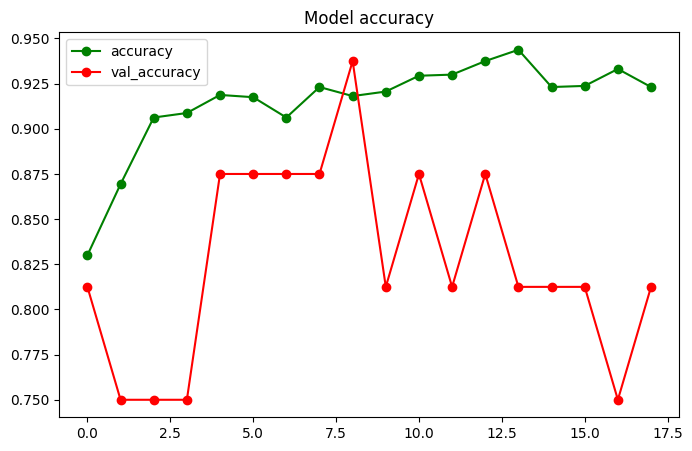

In [ ]:
plt.figure(figsize = (8, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

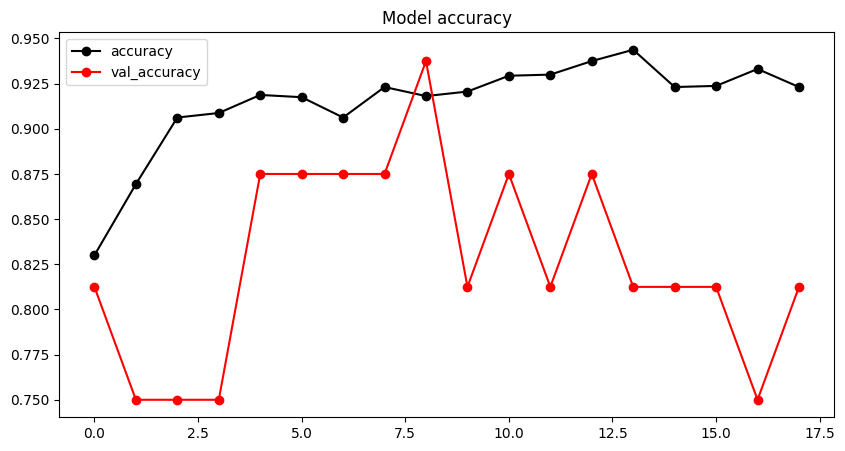

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], color="black", marker="o", linestyle="-")
plt.plot(history.history["val_accuracy"], color="red", marker="o", linestyle="-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

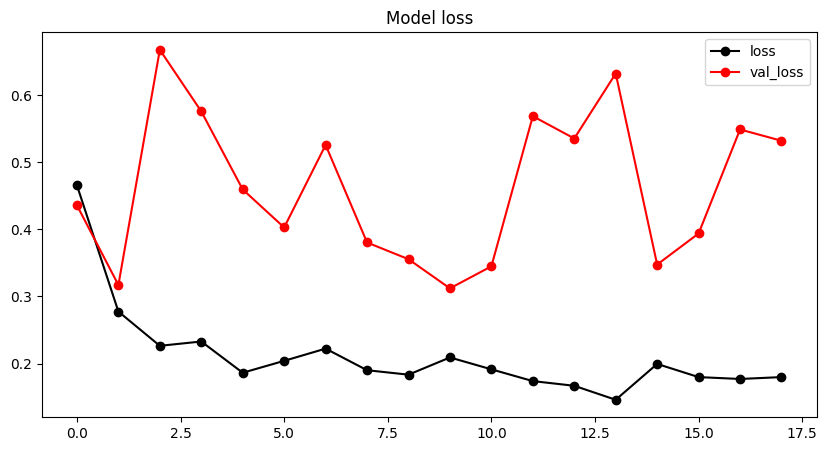

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"],color="black", marker="o", linestyle="-")
plt.plot(history.history["val_loss"], color="red", marker="o", linestyle="-")
plt.legend(["loss", "val_loss"])
plt.show()

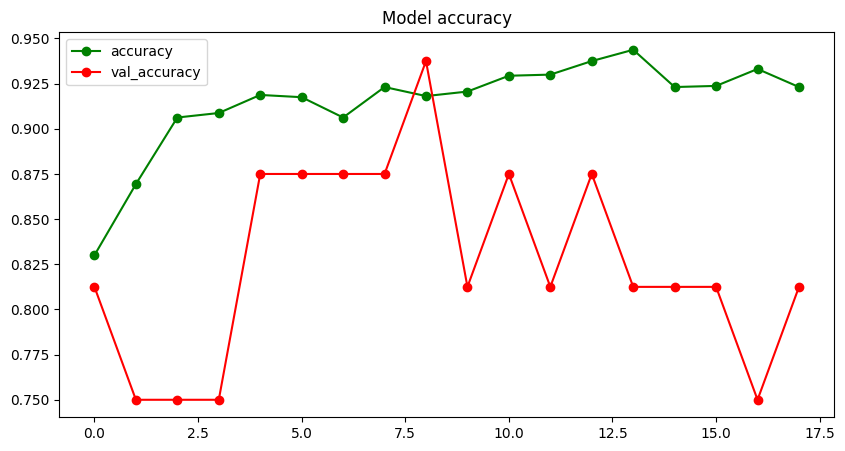

In [ ]:
plt.figure(figsize = (5, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

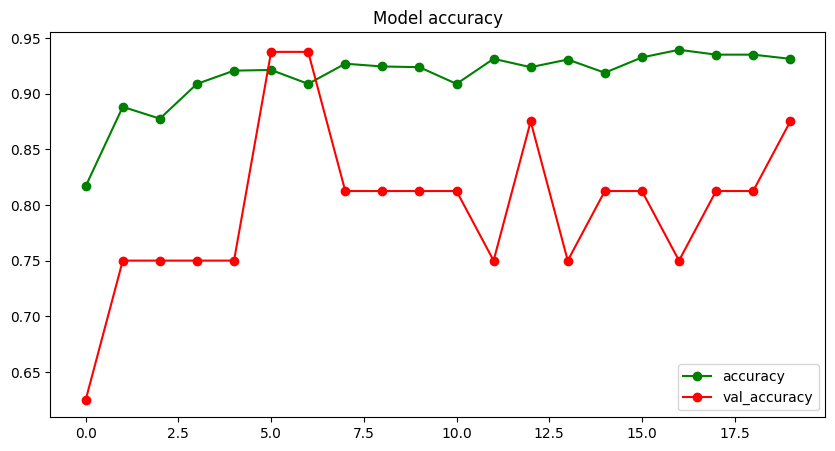

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

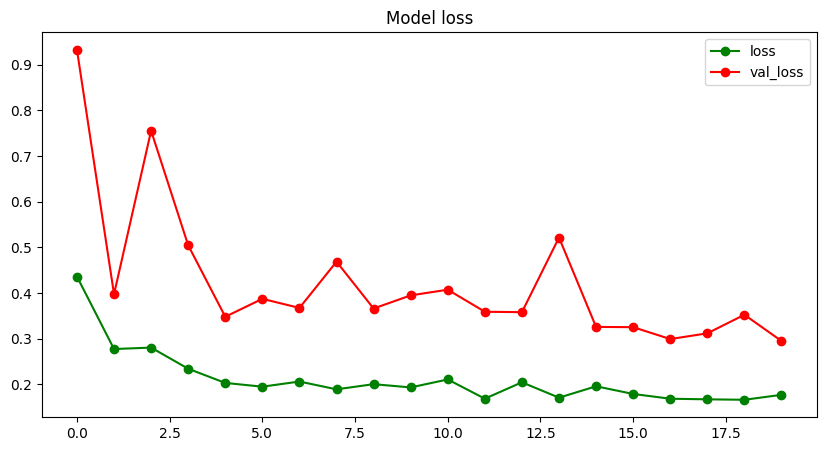

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

In [ ]:
test_loss, test_accuracy = model2.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

NameError: ignored

In [ ]:
model_loaded = tensorflow.keras.models.load_model("/content/drive/MyDrive/my_pneumonia_detection_model.h5")

In [ ]:
test_loss, test_accuracy = model3.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

43/50 [========================>.....] - ETA: 33s - loss: 0.3002 - accuracy: 0.8843

50/50 [==============================] - 205s 4s/step - loss: 0.3002 - accuracy: 0.8843
The testing accuracy is:  88.42729926109314 %
The testing loss is:  30.023720860481262 %


In [ ]:
model3.save("my_pneumonia_detection_model.h5")
print(colored("Model3 was succesfully saved to disk...", color = "green", attrs = ["bold", "dark"]))

Model3 was succesfully saved to disk...


In [ ]:
model_loaded = tensorflow.keras.models.load_model("/content/drive/MyDrive/my_pneumonia_detection_model.h5")
model_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,837,441
Trainable params: 272,641
Non

1/1 [==============================] - 1s 1s/step
This image is 88.204 percent N O R M A L


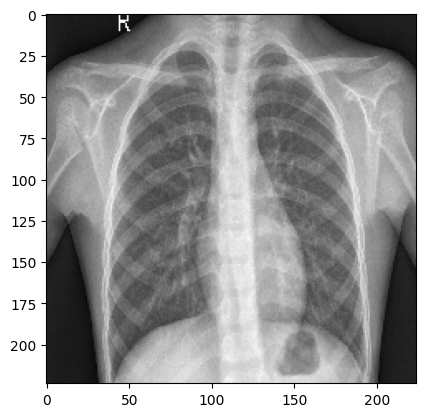

In [ ]:
def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    model_loaded = tensorflow.keras.models.load_model("/content/drive/MyDrive/my_pneumonia_detection_model.h5")
    prediction = model_loaded.predict(test_image)
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))


# call and use the function
image_prediction("/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0001-0001.jpeg")

1/1 [==============================] - 2s 2s/step
This image is 88.204 percent N O R M A L


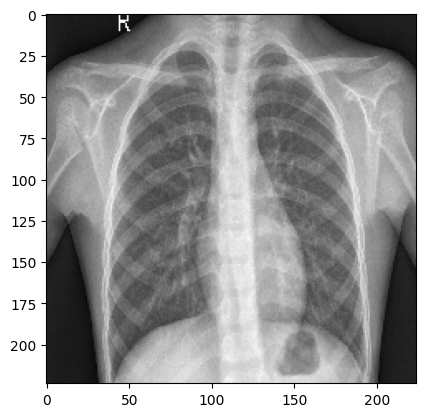

In [ ]:
def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    model_loaded = tensorflow.keras.models.load_model("/content/drive/MyDrive/my_pneumonia_detection_model.h5")
    prediction = model_loaded.predict(test_image)
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))


# call and use the function
image_prediction("/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0001-0001.jpeg")

# **Stage 2: Divide into 2 class**

In [ ]:
import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

os.environ['PYTHONHASHSEED'] = '73'

seed = 73
random.seed(seed)
np.random.seed(seed)

print(platform.platform())
%matplotlib inline

Linux-5.15.109+-x86_64-with-glibc2.35


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
DataDir = '/content/drive/MyDrive/input'
print('> Covid 19 dir:', os.listdir(DataDir))

> Covid 19 dir: ['test.txt', 'train.txt', '.DS_Store', 'test', 'train']


In [ ]:
PneumoniaDir = '/content/drive/MyDrive/chest_xray bacteria + virus'
print('> Pneumonia dir:', os.listdir(PneumoniaDir))

> Pneumonia dir: ['val', 'test', 'train', '.DS_Store']


In [ ]:
from tqdm import tqdm

train_image_dir = PneumoniaDir + '/train'
test_image_dir = PneumoniaDir + '/test'
val_image_dir = PneumoniaDir + '/val'

img_map = []

def prepareData(Dir, strat):
    cats = ["NORMAL","PNEUMONIA"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)

        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(train_image_dir,'train')
prepareData(test_image_dir,'test')
prepareData(val_image_dir, 'val')

img_map = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 9/9 [00:00<00:00, 96297.80it/s]


In [ ]:
#ricord, rsna, cohen, actmed, sirm,
def getClass(label):
    if label == 'negative':
        return 'NORMAL'
    if label == 'positive':
        return 'COVID'

def get_image_map(txt_path, strat):
    train_txt = open(txt_path, 'r')
    Lines = train_txt.readlines()
    paths = []

    img_formats = ['jpg', 'jpeg', 'png']

    for n, line in enumerate(Lines):
        querywords = line.split()

        if len(querywords) == 4:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[1]
            label = querywords[2]

        if len(querywords) == 5:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[2]
            label = querywords[3]

        for img_type in img_formats:
            if img_type in line:
                obj_ = {'path': image_path, 'label': getClass(label)}
                if (('positive' in line) | ('negative' in line)):
                    paths.append(obj_)

    paths_df = pd.DataFrame(paths)
    return paths_df

In [ ]:
train_map = get_image_map(DataDir + '/train.txt',
                          strat='train').sample(frac = 1, random_state=73)

test_map = get_image_map(DataDir + '/test.txt',
                         strat='test').sample(frac = 1, random_state=73)

In [ ]:
img_path_map = pd.concat([img_map, train_map, test_map], axis=0).sample(frac = 1, random_state=73)
img_path_map.head()

path   label
9611   /content/drive/MyDrive/input/train/ebb499bb-03...  NORMAL
10078  /content/drive/MyDrive/input/train/fbfada67-91...  NORMAL
26500  /content/drive/MyDrive/input/train/A441566-12-...   COVID
1816   /content/drive/MyDrive/input/train/MIDRC-RICOR...   COVID
5453   /content/drive/MyDrive/input/train/76197cfa-4a...  NORMAL

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

features = img_path_map['path'].to_numpy()
labels = img_path_map['label'].to_numpy()

stratified_sample = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=73)

In [ ]:
for train_index, test_index in stratified_sample.split(features, labels):
    X_train, test_X = features[train_index], features[test_index]
    y_train, test_y = labels[train_index], labels[test_index]

half_size = np.int(len(test_X) / 2)
X_test, y_test = test_X[0:half_size], test_y[0:half_size]
X_val, y_val = test_X[half_size:], test_y[half_size:]

<ipython-input-10-c24c9074a858>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  half_size = np.int(len(test_X) / 2)


In [ ]:
val_map = pd.DataFrame()
val_map['path'], val_map['label'] = X_val, y_val

In [ ]:
train_map = pd.DataFrame()
train_map['path'], train_map['label'] = X_train, y_train

In [ ]:
test_map = pd.DataFrame()
test_map['path'], test_map['label'] = X_test, y_test

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

features = img_path_map['path'].to_numpy()
labels = img_path_map['label'].to_numpy()

stratified_sample = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=73)

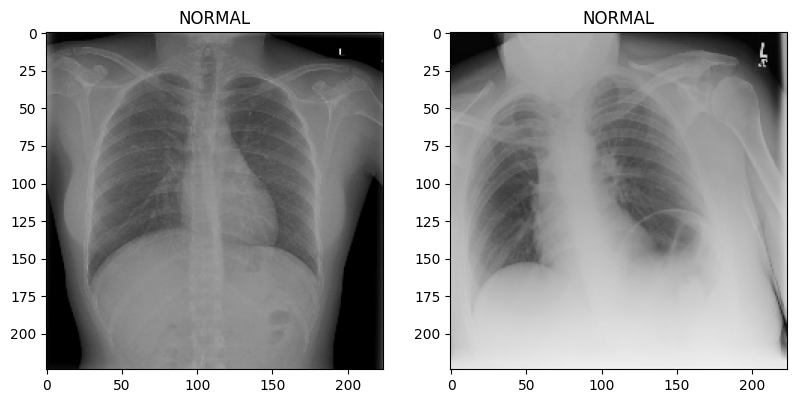

<Figure size 2000x800 with 0 Axes>

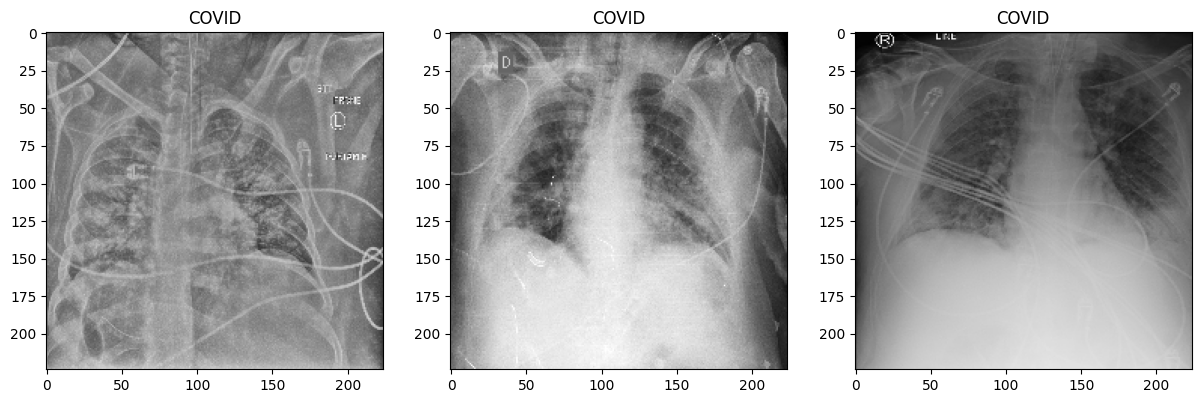

In [ ]:
import matplotlib.pyplot as plt

def print_images(samples):
    images = samples["path"].to_numpy()
    labels = samples['label'].to_numpy()

    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1

    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(labels[i])

        Sample_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)

        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)

    plt.show()

print_images(img_path_map[img_path_map['label']=="NORMAL"].iloc[0:2])
print_images(img_path_map[img_path_map['label']=="Bacteria PNEUMONIA"].iloc[0:3])
print_images(img_path_map[img_path_map['label']=="COVID"].iloc[0:3])

%matplotlib inline

**bulid model**

In [ ]:
import cv2
import time
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
ia.seed(73)

ColorCh = 3
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, ColorCh)

classes = ("COVID", "NORMAL","Bacteria PNEUMONIA")
CATEGORIES = sorted(classes)

print('> Classes:',CATEGORIES)

> Classes: ['Bacteria PNEUMONIA', 'COVID', 'NORMAL']


In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
# from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization

from tensorflow.keras.models import Model, Sequential
from keras import regularizers

kernel_regularizer = regularizers.l2(0.0001)

final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy'
n_classes = len(CATEGORIES)
print('> {} classes'.format(n_classes))

> 3 classes


In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255,
                             horizontal_flip=True,
                             brightness_range=[1.0,1.3],
                             rotation_range=15,
                             #zoom_range=0.2
                            )

In [ ]:
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(img_path_map)
print(label_count)

COVID        16194
NORMAL       15775
PNEUMONIA     4275
dtype: int64


In [ ]:
batch_size = 64

def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="sparse",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)
             )

    return generator

In [ ]:
train_df = train_map.sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

print('> label count for train set')
getLabelCount(train_df)

Found 18761 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 10234 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


> label count for train set


COVID        12955
NORMAL       12620
PNEUMONIA     3420
dtype: int64

In [ ]:
val_df = val_map.sample(frac=1, random_state=seed)
val_generator = get_generator(val_df)

print('> label count for val set')
getLabelCount(val_df)

Found 2344 validated image filenames belonging to 3 classes.
> label count for val set


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1281 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


COVID        1611
NORMAL       1590
PNEUMONIA     424
dtype: int64

In [ ]:
test_df = test_map.sample(frac=1, random_state=seed)
test_generator = get_generator(test_df)

print('> label count for test set')
getLabelCount(test_df)

Found 2336 validated image filenames belonging to 3 classes.
> label count for test set


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1288 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


COVID        1628
NORMAL       1565
PNEUMONIA     431
dtype: int64

In [ ]:
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output
    headModel = Dropout(0.5, seed=73)(headModel)
    headModel = Dense(n_classes, activation=final_activation)(headModel)
    model = Model(inputs = baseModel.input, outputs = headModel)
    5
    return model

In [ ]:
from keras.layers import concatenate


def Inception_block(input_layer, f1, f2, f3, f4):

    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    path2 = Conv2D(filters = f2[0], kernel_size = (1,1),
                   padding = 'same', activation = 'relu')(input_layer)

    path2 = Conv2D(filters = f2[1], kernel_size = (3,3),
                   padding = 'same', activation = 'relu')(path2)

    path3 = Conv2D(filters = f3[0], kernel_size = (1,1),
                   padding = 'same', activation = 'relu')(input_layer)

    path3 = Conv2D(filters = f3[1], kernel_size = (5,5),
                   padding = 'same', activation = 'relu')(path3)

    path4 = MaxPooling2D((3,3), strides= (1,1),
                         padding = 'same')(input_layer)

    path4 = Conv2D(filters = f4, kernel_size = (1,1),
                   padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

In [ ]:
def Extra_network_2(X):
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1),
                padding = 'same', activation = 'relu')(X2)

    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.5)(X2)
    X2 = Dense(n_classes, activation = final_activation, name="output2")(X2)
    return X2


def Extra_network_1(X):
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1),
                padding = 'same', activation = 'relu')(X1)

    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.5)(X1)
    X1 = Dense(n_classes, activation = final_activation, name="output1")(X1)
    return X1

In [ ]:
def layer_4(X):
    X = Inception_block(X, 192, (96, 208) , (16, 48), 64)

    X1 = Extra_network_1(X)

    X = Inception_block(X, 160, (112, 224), (24, 64), 64)
    X = Inception_block(X, 128, (128, 256), (24, 64), 64)
    X = Inception_block(X, 112, (144, 288), (32, 64), 64)

    X2 = Extra_network_2(X)

    X = Inception_block(X, 256, (160, 320), (32, 128), 128)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)

    return X, X1, X2

def layer_3(X):
    X = Inception_block(X, 64, (96, 128), (16, 32), 32)
    X = Inception_block(X, 128, (128, 192), (32, 96), 64)
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    return X
def layer_2(X):
    X = Conv2D(filters = 64,
               kernel_size = 1,
               strides = 1,
               padding = 'same',
               activation = 'relu')(X)

    X = Conv2D(filters = 192,
               kernel_size = 3,
               padding = 'same',
               activation = 'relu')(X)

    X = MaxPooling2D(pool_size= 3, strides = 2)(X)

    return X

In [ ]:
def load_GoogLeNet():
    input_layer = Input(shape = input_shape)

    X = Conv2D(64, kernel_size = 7, strides = 2,
               padding = 'valid', activation = 'relu')(input_layer)

    X = MaxPooling2D(pool_size = 3, strides = 2)(X)

    X = layer_2(X)
    X = layer_3(X)
    X, X1, X2 = layer_4(X)

    X = Inception_block(X, 256, (160, 320), (32, 128), 128)
    X = Inception_block(X, 384, (192, 384), (48, 128), 128)

    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.6)(X)

    X = Dense(n_classes, activation = final_activation, name="output3")(X)

    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model

load_GoogLeNet().summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 54, 54, 64)   0           ['conv2d[0][0]']                 
                                                                                          

# **DenseNet121**

In [ ]:
from keras.applications import DenseNet121

def load_DenseNet121():
    input_tensor = Input(shape=input_shape)
    baseModel = DenseNet121(pooling='avg',
                            include_top=False,
                            input_tensor=input_tensor)

    model = FCLayers(baseModel)
    return model

load_DenseNet121().summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
def getMetrics(name, type_):
    if name == 'GoogLeNet':
        if type_ == 'accuracy':
            return 'output3_accuracy'
        if type_ == 'loss':
            return 'output3_loss'
        if type_ == 'val_accuracy':
            return 'val_output3_accuracy'
        if type_ == 'val_loss':
            return 'val_output3_loss'

    else:
        if type_ == 'accuracy':
            return 'accuracy'
        if type_ == 'loss':
            return 'loss'
        if type_ == 'val_accuracy':
            return 'val_accuracy'
        if type_ == 'val_loss':
            return 'val_loss'

# **Callback**

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

EPOCHS = 120
patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

        from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

EPOCHS = 6
patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

def getCallbacks(name):
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get(getMetrics(name,'accuracy'))>=0.999)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True


    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

    early_stopping = EarlyStopping(patience = patience, monitor=getMetrics(name, 'val_loss'),
                                 mode='min', restore_best_weights=True,
                                 verbose = 1, min_delta = .00075)


    checkpoint_filepath = name + '_Weights.h5'

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor=getMetrics(name, 'val_loss'),
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

    import datetime
    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback,
             lr_callback,
             model_checkpoints,
             early_stopping,
             #tensorboard_callback,
             lr_plat
            ]

GoogLeNet_callbacks = getCallbacks('GoogLeNet')
callbacks = getCallbacks('DenseNet121')

In [ ]:
def BuildModel(name):
    if name == 'GoogLeNet':
        prepared_model = load_GoogLeNet()
    if name == 'DenseNet121':
        prepared_model = load_DenseNet121()
    compiled_model = CompileModel(name, prepared_model)
    return compiled_model

In [ ]:
model_loaded = tensorflow.keras.models.load_model("/content/drive/MyDrive/my_pneumonia_detection_model.h5")

In [ ]:
def CompileModel(name, model):
    if name == 'GoogLeNet':
        model.compile(optimizer='adam', loss=entropy, metrics={"output1":"accuracy", "output2":"accuracy", "output3":"accuracy"})
    else:
        model.compile(optimizer='adam', loss=entropy, metrics=["accuracy"])
    return model

def FitModel(model, name):
    callbacks_ = callbacks
    if name == 'GoogLeNet':
        callbacks_ = GoogLeNet_callbacks
    history = model.fit(train_generator,
                        epochs=EPOCHS,
                        callbacks=callbacks_,
                        validation_data = val_generator,
                        steps_per_epoch=(len(train_generator.labels) / 80),
                        validation_steps=(len(val_generator.labels) / 80),
                       )

    model.load_weights(name + '_Weights.h5')

    final_accuracy_avg = np.mean(history.history[getMetrics(name, "val_accuracy")][-5:])

    final_loss = history.history[getMetrics(name, "val_loss")][-1]

    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss: 'loss'}

    print('\n')
    print('---'*15)
    print(name,' Model')
    print('Total Epochs :', len(history.history[getMetrics(name, 'loss')]))
    print('Restoring best Weights')

    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('---'*15)
    print('Best Epoch :', index)
    print('---'*15)

    train_accuracy = history.history[getMetrics(name, 'accuracy')][index]
    train_loss = history.history[getMetrics(name, 'loss')][index]

    val_accuracy = history.history[getMetrics(name, 'val_accuracy')][index]
    val_loss = history.history[getMetrics(name, 'val_loss')][index]

    print('Accuracy on train:', train_accuracy,
          '\tLoss on train:', train_loss)

    print('Accuracy on val:', val_accuracy ,
          '\tLoss on val:', val_loss)
    print('---'*15)

    return model, history

# **GoogLeNet train model**

In [ ]:
d_compiled_model = BuildModel('DenseNet121')
d_model, d_history = FitModel(d_compiled_model, 'DenseNet121')

235/234 [==============================] - ETA: -26s - loss: 0.5869 - accuracy: 0.7628
Epoch 1: val_loss improved from inf to 0.39043, saving model to DenseNet121_Weights.h5
234/234 [==============================] - 13698s 58s/step - loss: 0.5869 - accuracy: 0.7628 - val_loss: 0.3904 - val_accuracy: 0.8458 - lr: 1.0000e-05


---------------------------------------------
DenseNet121  Model
Total Epochs : 1
Restoring best Weights
---------------------------------------------
Best Epoch : -3
---------------------------------------------


IndexError: ignored

In [ ]:
g_compiled_model = BuildModel('GoogLeNet')
g_model, g_history = FitModel(g_compiled_model, 'GoogLeNet')

Epoch 1/10
61/60 [==============================] - ETA: -7s - loss: 2.9993 - output3_loss: 1.0168 - output1_loss: 0.9914 - output2_loss: 0.9911 - output3_accuracy: 0.6912 - output1_accuracy: 0.6860 - output2_accuracy: 0.6904
Epoch 1: val_output3_loss improved from inf to 0.78864, saving model to GoogLeNet_Weights.h5
60/60 [==============================] - 1498s 24s/step - loss: 2.9993 - output3_loss: 1.0168 - output1_loss: 0.9914 - output2_loss: 0.9911 - output3_accuracy: 0.6912 - output1_accuracy: 0.6860 - output2_accuracy: 0.6904 - val_loss: 2.3592 - val_output3_loss: 0.7886 - val_output1_loss: 0.8084 - val_output2_loss: 0.7621 - val_output3_accuracy: 0.6973 - val_output1_accuracy: 0.6973 - val_output2_accuracy: 0.6973 - lr: 1.0000e-05
Epoch 2/10
61/60 [==============================] - ETA: -7s - loss: 2.2020 - output3_loss: 0.7378 - output1_loss: 0.7333 - output2_loss: 0.7309 - output3_accuracy: 0.7084 - output1_accuracy: 0.7086 - output2_accuracy: 0.7086
Epoch 2: val_output3_los

# **Model Evaluation on the TestSet**

In [ ]:
model_summary(g_model, g_history, 'GoogLeNet')

In [ ]:
%matplotlib inline
def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [ ]:
pip install --upgrade scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

def test_set_results(pred_value, n=1):
    y_test = test_generator.labels
    X_test, _ = test_generator.next()

    corr_pred = metrics.confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()

    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Dense Output {}'.format(n))
    plt.show()

    n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)

    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)

    print(classification_report(test_generator.labels, pred_value, target_names=CATEGORIES))

In [ ]:
def printResults(name, model):
    predictions = model.predict(test_generator, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [ ]:
def model_summary(model, history, name):
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('Best Epochs: ', index)

    if name == 'GoogLeNet':
        results = model.evaluate(test_generator, verbose=1)
        loss, output3_loss, output1_loss, output2_loss, output3_accuracy, output1_accuracy, output2_accuracy = results

        for i in range(3):
            n = i + 1
            out_layer = 'Output Layer {}'.format(n)

            if n == 1:
                test_accuracy = output1_accuracy
                test_loss = output1_loss

            if n == 2:
                test_accuracy = output2_accuracy
                test_loss = output2_loss

            if n == 3:
                test_accuracy = output3_accuracy
                test_loss = output3_loss


            output_name = 'output{}_'.format(n)
            train_accuracy, train_loss = history.history[output_name + 'accuracy'][index], history.history[output_name + 'loss'][index]


            print_graph(output_name + 'loss', index, history)
            print_graph(output_name + 'accuracy', index, history)

            print('---'*15)
            print('GoogLeNet Dense output {}:'.format(n))

            print('> Accuracy on train :'.format(out_layer), train_accuracy,
                  '\tLoss on train:',train_loss)

            print('> Accuracy on test :'.format(out_layer), test_accuracy,
                  '\tLoss on test:',test_loss)

            print('---'*15)
            print('> predicting test')
            print('---'*15)

            predictions = model.predict(test_generator, verbose=1)
            preds = np.argmax(predictions[i], axis=1)
            test_set_results(preds, n)

    else:
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print_graph('loss', index, history)
        print_graph('accuracy', index, history)

        print('---'*15)
        print(name)
        print('> Accuracy on train:',train_accuracy,
              '\tLoss on train:',train_loss)

        print('> Accuracy on test:',test_accuracy,
              '\tLoss on test:',test_loss)

        print('---'*15)
        print('> predicting test')
        print('---'*15)

        printResults(name, model)

# **GoogLeNet Results**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

NameError: ignored

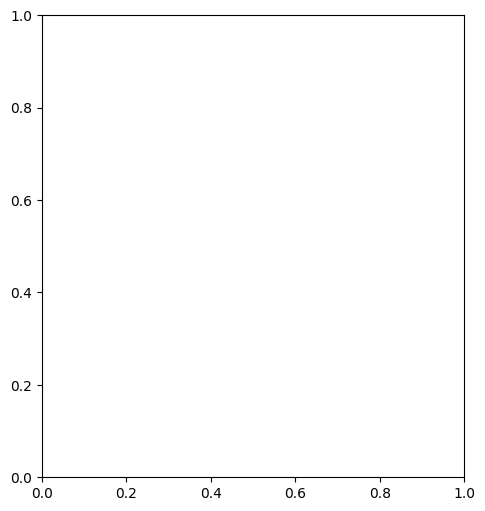

In [ ]:
# Plotting train/validation loss and accuracy curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(g_history.history['loss'], label='Train Loss')
plt.plot(g_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(g_history.history['accuracy'], label='Train Accuracy')
plt.plot(g_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Val Accuracy Curve')
plt.legend()

plt.show()


In [ ]:
  # Plotting train/validation loss and accuracy curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history[getMetrics(name, 'loss')], label='Train Loss')
    plt.plot(history.history[getMetrics(name, 'val_loss')], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train/Val Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history[getMetrics(name, 'accuracy')], label='Train Accuracy')
    plt.plot(history.history[getMetrics(name, 'val_accuracy')], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train/Val Accuracy Curve')
    plt.legend()
    plt.show()

IndentationError: ignored

In [ ]:
    y_true = np.argmax(val_generator.labels, axis=1)
    y_pred_probs = model.predict(val_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

AxisError: ignored

Best Epochs:  6
10/10 [==============================] - 115s 12s/step - loss: 0.7308 - output3_loss: 0.2193 - output1_loss: 0.2866 - output2_loss: 0.2249 - output3_accuracy: 0.9182 - output1_accuracy: 0.8915 - output2_accuracy: 0.9182


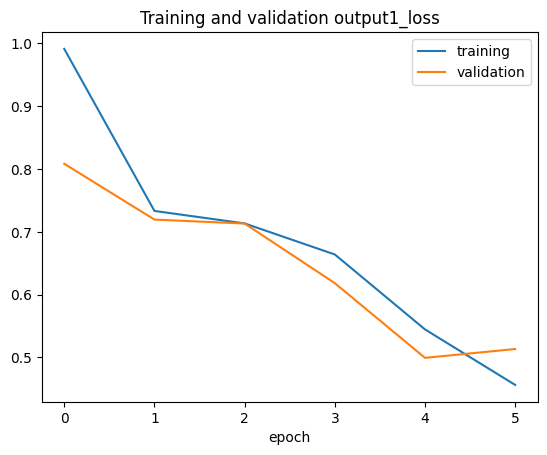

<Figure size 640x480 with 0 Axes>

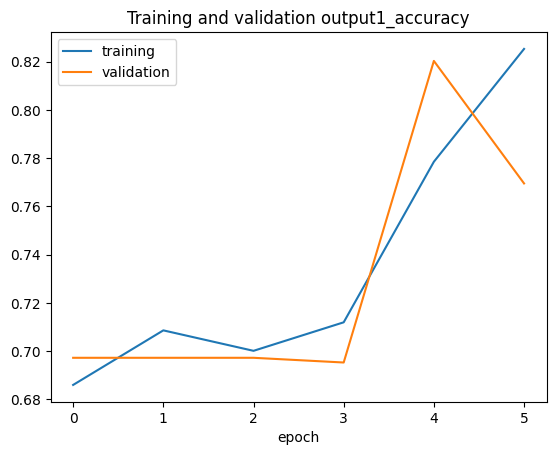

---------------------------------------------
GoogLeNet Dense output 1:
> Accuracy on train : 0.8322199583053589 	Loss on train: 0.431293785572052
> Accuracy on test : 0.8914858102798462 	Loss on test: 0.28655490279197693
---------------------------------------------
> predicting test
---------------------------------------------
10/10 [==============================] - 73s 7s/step


<Figure size 640x480 with 0 Axes>

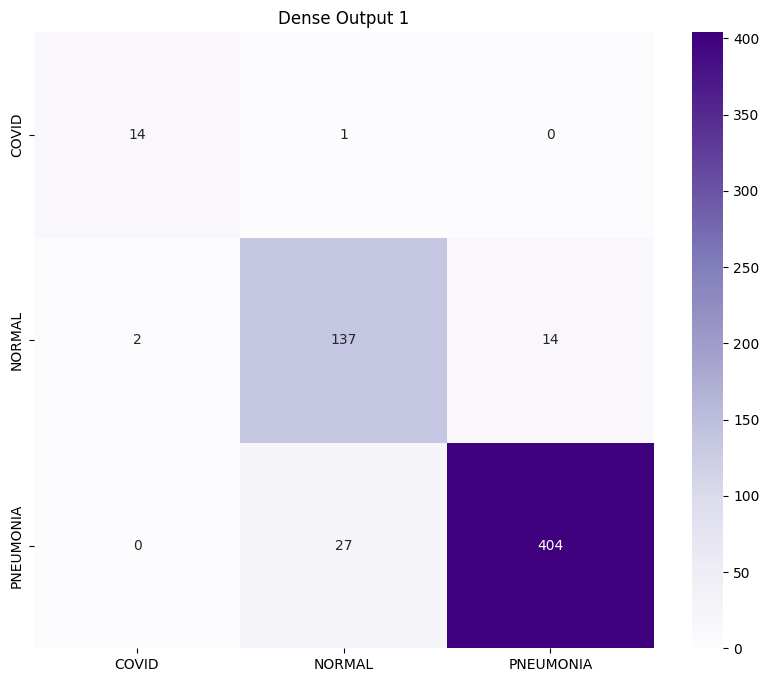

<ipython-input-45-7423ab9628b8>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


.............................................
> Correct Predictions: 555
> Wrong Predictions: 44
.............................................
              precision    recall  f1-score   support

       COVID       0.88      0.93      0.90        15
      NORMAL       0.83      0.90      0.86       153
   PNEUMONIA       0.97      0.94      0.95       431

    accuracy                           0.93       599
   macro avg       0.89      0.92      0.91       599
weighted avg       0.93      0.93      0.93       599



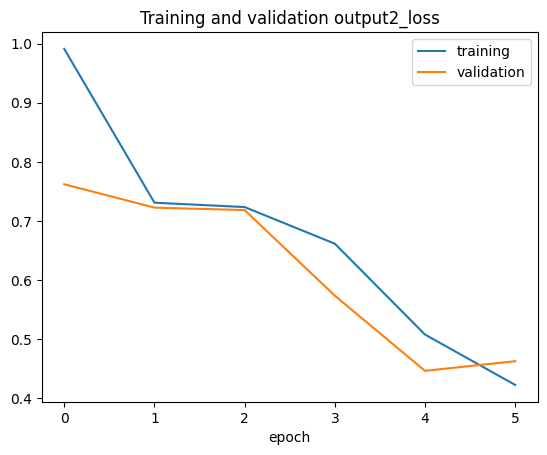

<Figure size 640x480 with 0 Axes>

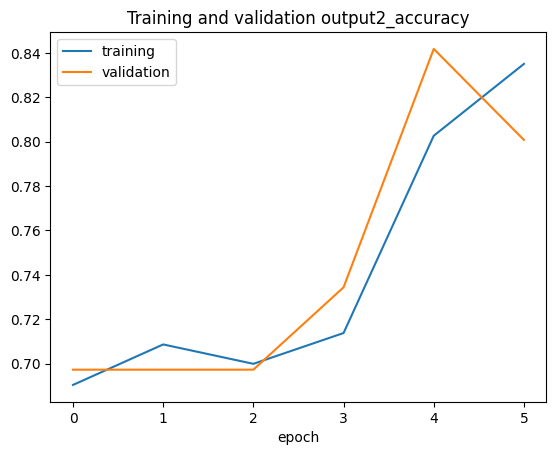

---------------------------------------------
GoogLeNet Dense output 2:
> Accuracy on train : 0.8450667858123779 	Loss on train: 0.39906859397888184
> Accuracy on test : 0.918196976184845 	Loss on test: 0.22492636740207672
---------------------------------------------
> predicting test
---------------------------------------------
10/10 [==============================] - 57s 6s/step


<Figure size 640x480 with 0 Axes>

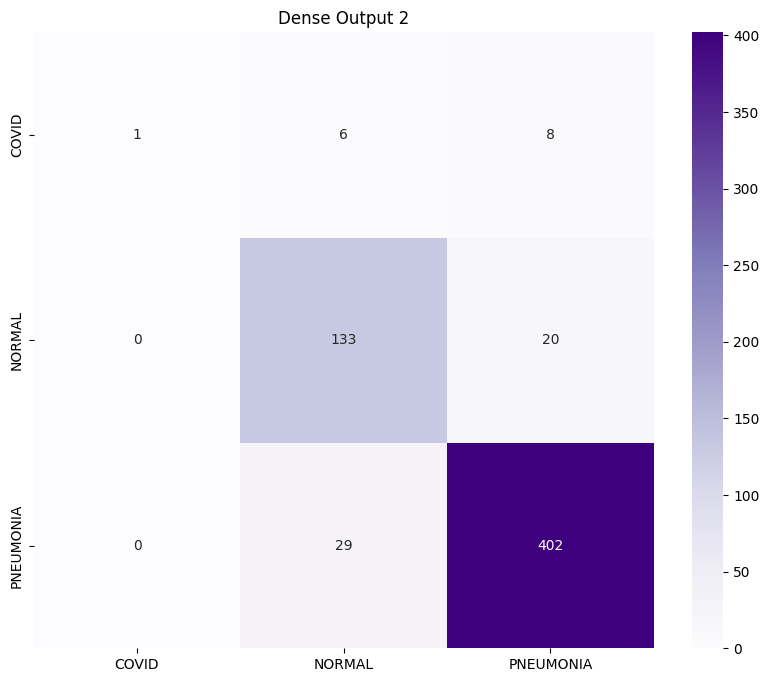

<ipython-input-45-7423ab9628b8>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


.............................................
> Correct Predictions: 536
> Wrong Predictions: 63
.............................................
              precision    recall  f1-score   support

       COVID       1.00      0.07      0.12        15
      NORMAL       0.79      0.87      0.83       153
   PNEUMONIA       0.93      0.93      0.93       431

    accuracy                           0.89       599
   macro avg       0.91      0.62      0.63       599
weighted avg       0.90      0.89      0.89       599



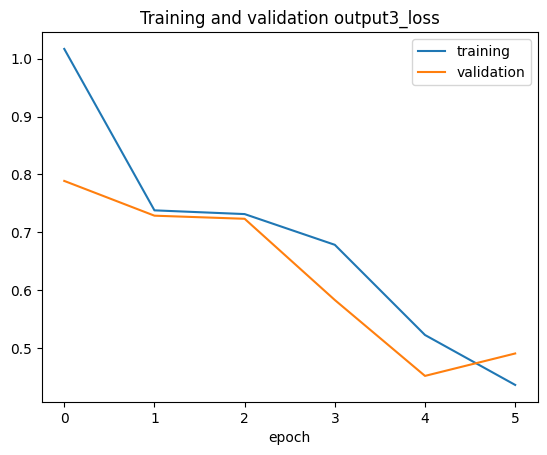

<Figure size 640x480 with 0 Axes>

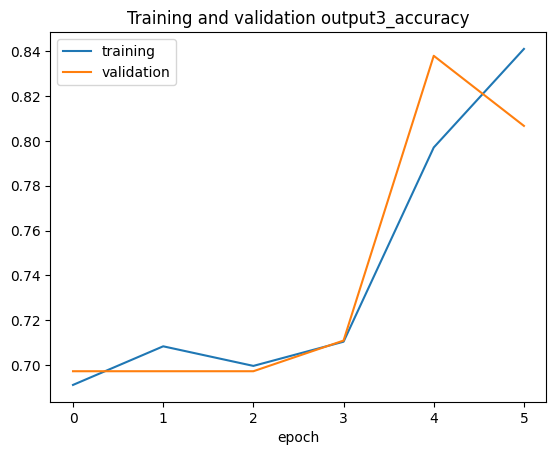

---------------------------------------------
GoogLeNet Dense output 3:
> Accuracy on train : 0.844809889793396 	Loss on train: 0.4229341745376587
> Accuracy on test : 0.918196976184845 	Loss on test: 0.21933238208293915
---------------------------------------------
> predicting test
---------------------------------------------
10/10 [==============================] - 57s 5s/step


<Figure size 640x480 with 0 Axes>

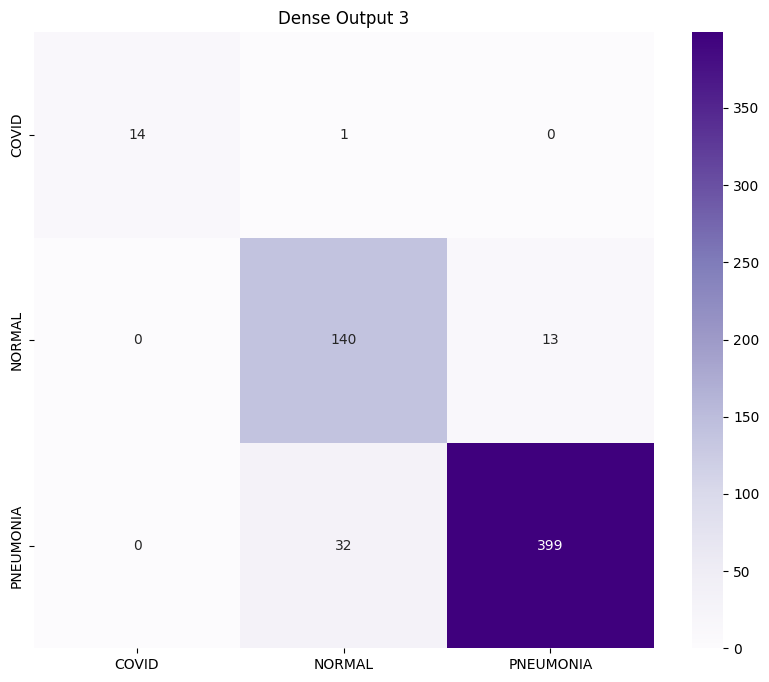

.............................................
> Correct Predictions: 553
> Wrong Predictions: 46
.............................................
              precision    recall  f1-score   support

       COVID       1.00      0.93      0.97        15
      NORMAL       0.81      0.92      0.86       153
   PNEUMONIA       0.97      0.93      0.95       431

    accuracy                           0.92       599
   macro avg       0.93      0.92      0.92       599
weighted avg       0.93      0.92      0.92       599



<ipython-input-45-7423ab9628b8>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


In [ ]:
model_summary(g_model, g_history, 'GoogLeNet')

# **DenseNet121 Results**

In [ ]:
model_summary(d_model, d_history, 'DenseNet121')

NameError: ignored

# **CNN**

In [ ]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.12.0


In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

In [ ]:
with strategy.scope():
    reconstructed_model = keras.models.load_model("/content/drive/MyDrive/my_pneumonia_detection_model.h5")
    reconstructed_model.pop()
    reconstructed_model.add(keras.layers.Dense(3, activation='softmax'))

    METRICS = [
        'accuracy',
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]

    reconstructed_model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=METRICS,
    )

In [ ]:
history = reconstructed_model.fit(
    train_df,
    validation_data=val_df,
    epochs=20,
    callbacks=[early_stopping_cb]
)

ValueError: ignored